# Wine_Hybrid: Two-Phase Training Approach

This notebook implements a hybrid approach to gradient-guided hypothesis selection:

**Phase 1: Unbiased Signal Extraction**
- Train on ALL hypotheses equally (no selection)
- Use architecture that AMPLIFIES hypothesis feature impact on gradients
- Last N epochs: record per-hypothesis losses and gradients
- Goal: Gather clean, unbiased data about each hypothesis

**Phase 2: Informed GGH Selection**
- Use Phase 1 insights to guide hypothesis selection
- Standard GGH or winner-take-all training

**Key insight**: Phase 1 gradients are not contaminated by selection feedback loop.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../GGH')

from GGH.data_ops import DataOperator
from GGH.selection_algorithms import AlgoModulators, compute_individual_grads_nothread
from GGH.models import initialize_model, load_model
from GGH.train_val_loop import TrainValidationManager
from GGH.inspector import Inspector, visualize_train_val_error, selection_histograms
from GGH.custom_optimizer import CustomAdam
from sklearn.metrics import r2_score
from torch.autograd import grad
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def set_to_deterministic(rand_state):
    import random
    random.seed(rand_state)
    np.random.seed(rand_state)
    torch.manual_seed(rand_state)
    torch.set_num_threads(1)
    torch.use_deterministic_algorithms(True)

# ADAPTIVE CONTEXT UTILITIES
# Based on diagnostic finding: use gradient-only when anchor_similarity < 0, 
# enriched (gradient + features) when anchor_similarity > 0

def compute_anchor_data(trainer, DO):
    """
    Compute gradient-only anchors AND enriched anchors for each class.
    Also computes anchor_similarity to decide which method to use per class.
    """
    analysis = trainer.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    input_cols = DO.inpt_vars
    
    # Get partial data
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    # Compute all anchors per class
    anchor_correct_grad = {}
    anchor_incorrect_grad = {}
    anchor_correct_enriched = {}
    anchor_incorrect_enriched = {}
    anchor_similarity_grad = {}  # Gradient-only similarity
    anchor_similarity_enriched = {}  # Enriched similarity
    use_enriched = {}
    
    # For normalization: collect all gradients to get scale
    all_grads = [analysis[gid]['avg_gradient'] for gid in analysis 
                 if analysis[gid]['avg_gradient'] is not None]
    grad_scale = float(np.mean([np.linalg.norm(g) for g in all_grads])) if all_grads else 1.0
    
    # Store normalization params per class for use in scoring
    feature_norm_params = {}
    
    for class_id in range(hyp_per_sample):
        class_correct_gids = [gid for gid in partial_correct_gids 
                              if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        class_incorrect_gids = [gid for gid in blacklisted_gids 
                                if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        
        # Collect gradients and features for correct
        correct_grads = []
        correct_features = []
        for gid in class_correct_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None:
                correct_grads.append(analysis[gid]['avg_gradient'])
                feat = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
                correct_features.append(feat)
        
        # Collect gradients and features for incorrect
        incorrect_grads = []
        incorrect_features = []
        for gid in class_incorrect_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None:
                incorrect_grads.append(analysis[gid]['avg_gradient'])
                feat = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
                incorrect_features.append(feat)
        
        if not correct_grads or not incorrect_grads:
            continue
            
        # Gradient-only anchors
        anchor_correct_grad[class_id] = np.mean(correct_grads, axis=0)
        anchor_incorrect_grad[class_id] = np.mean(incorrect_grads, axis=0)
        
        # Compute gradient-only anchor similarity
        sim_grad = float(np.dot(anchor_correct_grad[class_id], anchor_incorrect_grad[class_id]) / (
            np.linalg.norm(anchor_correct_grad[class_id]) * np.linalg.norm(anchor_incorrect_grad[class_id]) + 1e-8))
        anchor_similarity_grad[class_id] = sim_grad
        
        # Decide: use enriched if gradient anchor_similarity > 0
        use_enriched[class_id] = sim_grad > 0
        
        # Enriched anchors (gradient + normalized features)
        correct_grads = np.array(correct_grads, dtype=np.float64)
        incorrect_grads = np.array(incorrect_grads, dtype=np.float64)
        correct_features = np.array(correct_features, dtype=np.float64)
        incorrect_features = np.array(incorrect_features, dtype=np.float64)
        
        # Normalize features to gradient scale
        all_features = np.vstack([correct_features, incorrect_features])
        feat_mean = np.mean(all_features, axis=0)
        feat_std = np.std(all_features, axis=0) + 1e-8
        
        # Store normalization params for this class
        feature_norm_params[class_id] = {'mean': feat_mean, 'std': feat_std, 'scale': grad_scale}
        
        correct_features_norm = (correct_features - feat_mean) / feat_std * grad_scale
        incorrect_features_norm = (incorrect_features - feat_mean) / feat_std * grad_scale
        
        # Enriched = gradient + normalized features
        correct_enriched = np.hstack([correct_grads, correct_features_norm])
        incorrect_enriched = np.hstack([incorrect_grads, incorrect_features_norm])
        
        anchor_correct_enriched[class_id] = np.mean(correct_enriched, axis=0)
        anchor_incorrect_enriched[class_id] = np.mean(incorrect_enriched, axis=0)
        
        # Compute enriched anchor similarity
        sim_enriched = float(np.dot(anchor_correct_enriched[class_id], anchor_incorrect_enriched[class_id]) / (
            np.linalg.norm(anchor_correct_enriched[class_id]) * np.linalg.norm(anchor_incorrect_enriched[class_id]) + 1e-8))
        anchor_similarity_enriched[class_id] = sim_enriched
    
    return {
        'anchor_correct_grad': anchor_correct_grad,
        'anchor_incorrect_grad': anchor_incorrect_grad,
        'anchor_correct_enriched': anchor_correct_enriched,
        'anchor_incorrect_enriched': anchor_incorrect_enriched,
        'anchor_similarity_grad': anchor_similarity_grad,
        'anchor_similarity_enriched': anchor_similarity_enriched,
        'use_enriched': use_enriched,
        'grad_scale': grad_scale,
        'feature_norm_params': feature_norm_params,
        'partial_correct_gids': partial_correct_gids,
        'blacklisted_gids': blacklisted_gids,
        'partial_sample_indices': partial_sample_indices,
        'input_cols': input_cols
    }


def compute_adaptive_score(gradient, features, class_id, anchor_data):
    """
    Compute score using adaptive method:
    - Gradient-only for classes with good gradient separation (anchor_sim < 0)
    - Enriched (gradient + features) for classes with poor gradient separation (anchor_sim > 0)
    """
    use_enriched = anchor_data['use_enriched'].get(class_id, False)
    
    if use_enriched:
        # Use enriched vectors - normalize features using stored params
        norm_params = anchor_data['feature_norm_params'].get(class_id)
        if norm_params:
            features_norm = (features - norm_params['mean']) / norm_params['std'] * norm_params['scale']
        else:
            features_norm = features
        enriched = np.concatenate([gradient, features_norm])
        
        anchor_c = anchor_data['anchor_correct_enriched'].get(class_id)
        anchor_i = anchor_data['anchor_incorrect_enriched'].get(class_id)
    else:
        # Use gradient-only
        enriched = gradient
        anchor_c = anchor_data['anchor_correct_grad'].get(class_id)
        anchor_i = anchor_data['anchor_incorrect_grad'].get(class_id)
    
    if anchor_c is None:
        return 0.0
    
    sim_c = float(np.dot(enriched, anchor_c) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_c) + 1e-8))
    
    if anchor_i is not None:
        sim_i = float(np.dot(enriched, anchor_i) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_i) + 1e-8))
    else:
        sim_i = 0.0
    
    return sim_c - sim_i


def print_adaptive_method_summary(anchor_data, hyp_per_sample):
    """Print summary of adaptive method selection per class."""
    print("Per-class method selection:")
    for class_id in range(hyp_per_sample):
        use_enr = anchor_data['use_enriched'].get(class_id, False)
        sim_grad = anchor_data['anchor_similarity_grad'].get(class_id, None)
        sim_enr = anchor_data['anchor_similarity_enriched'].get(class_id, None)
        
        if use_enr:
            # Show BOTH: gradient sim (why we switched) and enriched sim (what we use)
            print(f"  Class {class_id}: grad_sim={sim_grad:+.3f} (poor) → ENRICHED (enriched_sim={sim_enr:+.3f})")
        else:
            print(f"  Class {class_id}: grad_sim={sim_grad:+.3f} (good) → GRADIENT-ONLY")




def compute_score_stats(trainer, DO, anchor_data):
    """
    First pass: Compute raw scores for all samples and collect statistics per class.
    This is needed for Z-score normalization.
    """
    analysis = trainer.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    input_cols = anchor_data['input_cols']
    
    partial_sample_indices = anchor_data['partial_sample_indices']
    blacklisted_gids = anchor_data['blacklisted_gids']
    
    # Collect raw scores per class
    class_scores = {c: [] for c in range(hyp_per_sample)}
    
    for sample_idx in range(n_samples):
        if sample_idx in partial_sample_indices:
            continue
        
        start = sample_idx * hyp_per_sample
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in blacklisted_gids:
                continue
            if gid not in analysis or analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
            
            # Compute raw adaptive score
            raw_score = compute_adaptive_score(gradient, features, class_id, anchor_data)
            class_scores[class_id].append(raw_score)
    
    # Compute statistics per class
    score_stats = {}
    for class_id in range(hyp_per_sample):
        scores = class_scores[class_id]
        if len(scores) > 0:
            score_stats[class_id] = {
                'mean': float(np.mean(scores)),
                'std': float(np.std(scores)),
                'min': float(np.min(scores)),
                'max': float(np.max(scores)),
                'count': len(scores)
            }
        else:
            score_stats[class_id] = {'mean': 0.0, 'std': 1.0, 'min': 0.0, 'max': 0.0, 'count': 0}
    
    return score_stats


def compute_adaptive_score_normalized(gradient, features, class_id, anchor_data):
    """
    Compute score and normalize using pre-computed class statistics.
    This ensures all classes have comparable score scales (mean~0, std~1).
    """
    raw_score = compute_adaptive_score(gradient, features, class_id, anchor_data)
    
    # Normalize using class-specific mean and std
    score_stats = anchor_data.get('score_stats', {})
    if class_id in score_stats:
        stats = score_stats[class_id]
        normalized_score = (raw_score - stats['mean']) / (stats['std'] + 1e-8)
    else:
        normalized_score = raw_score
    
    return normalized_score


def compute_anchor_data_with_stats(trainer, DO):
    """
    Wrapper that computes anchor data AND score statistics.
    Call this instead of compute_anchor_data when using normalized scores.
    """
    # First compute anchor data
    anchor_data = compute_anchor_data(trainer, DO)
    
    # Then compute score statistics using raw adaptive scores
    score_stats = compute_score_stats(trainer, DO, anchor_data)
    
    # Add stats to anchor_data
    anchor_data['score_stats'] = score_stats
    
    return anchor_data


def print_score_stats(anchor_data, hyp_per_sample):
    """Print score statistics per class."""
    print("\nScore statistics per class (for Z-score normalization):")
    print("-" * 60)
    score_stats = anchor_data.get('score_stats', {})
    for class_id in range(hyp_per_sample):
        if class_id in score_stats:
            stats = score_stats[class_id]
            use_enr = anchor_data['use_enriched'].get(class_id, False)
            method = "enriched" if use_enr else "grad-only"
            print(f"  Class {class_id} ({method}): mean={stats['mean']:+.3f}, std={stats['std']:.3f}, range=[{stats['min']:.2f}, {stats['max']:.2f}]")



print("Adaptive context utilities loaded (with Z-score normalization).")
print("  - compute_anchor_data(trainer, DO): Compute all anchors")
print("  - compute_anchor_data_with_stats(trainer, DO): Compute anchors + score stats for normalization")
print("  - compute_adaptive_score(gradient, features, class_id, anchor_data): Raw adaptive score")
print("  - compute_adaptive_score_normalized(gradient, features, class_id, anchor_data): Z-score normalized")
print("  - print_adaptive_method_summary(anchor_data, hyp_per_sample): Show method per class")
print("  - print_score_stats(anchor_data, hyp_per_sample): Show score statistics per class")


    
print("Imports successful!")

Adaptive context utilities loaded (with Z-score normalization).
  - compute_anchor_data(trainer, DO): Compute all anchors
  - compute_anchor_data_with_stats(trainer, DO): Compute anchors + score stats for normalization
  - compute_adaptive_score(gradient, features, class_id, anchor_data): Raw adaptive score
  - compute_adaptive_score_normalized(gradient, features, class_id, anchor_data): Z-score normalized
  - print_adaptive_method_summary(anchor_data, hyp_per_sample): Show method per class
  - print_score_stats(anchor_data, hyp_per_sample): Show score statistics per class
Imports successful!


In [2]:
# Data configuration
data_path = '../data/wine/red_wine.csv'
results_path = "../saved_results/Red Wine Hybrid"
inpt_vars = ['volatile acidity', 'total sulfur dioxide', 'citric acid'] 
target_vars = ['quality']
miss_vars = ['alcohol']

# Hypothesis values based on natural breaks in alcohol distribution:
# - Boundary at 9.7: after the major peak at 9.4-9.6 (245 samples)
# - Boundary at 10.4: between plateau regions
# - Boundary at 11.4: before sparse tail
# Coverage: 31.1%, 23.6%, 25.8%, 19.5% (vs old 31%, 34%, 34%, 1.3%!)
# Each hypothesis ≈ class mean: 9.4→9.36, 10.0→9.97, 10.8→10.82, 12.0→12.14
#hypothesis = [[9.4, 10.0, 10.8, 12.0]]
hypothesis = [[9.4, 10.5, 12.0]]

# Model parameters
hidden_size = 32
output_size = len(target_vars)
hyp_per_sample = len(hypothesis[0])
batch_size = 100 * hyp_per_sample  # 400

# Training parameters
partial_perc = 0.025  # 2.5% complete data
rand_state = 0
lr = 0.001

# Phase 1 parameters - EXPERIMENT 1: EXTENDED TRAINING
phase1_epochs = 30  # Was 30 - now 100 for more stable gradients
phase1_analysis_epochs = 10  # Was 10 - now 20 for better gradient averaging

# Phase 2 parameters  
phase2_epochs = 200  # GGH selection training (was 50, using Wine.ipynb standard)

# Create directories
import os
os.makedirs(results_path, exist_ok=True)
for folder in ['phase1', 'phase2', 'use hypothesis', 'partial info', 'use known only', 'full info']:
    os.makedirs(f'{results_path}/{folder}', exist_ok=True)

print(f"Results will be saved to: {results_path}")
print(f"Phase 1: {phase1_epochs} epochs (track last {phase1_analysis_epochs}) - EXTENDED")
print(f"Phase 2: {phase2_epochs} epochs with GGH selection")
print(f"Hypothesis values: {hypothesis[0]}")

Results will be saved to: ../saved_results/Red Wine Hybrid
Phase 1: 30 epochs (track last 10) - EXTENDED
Phase 2: 200 epochs with GGH selection
Hypothesis values: [9.4, 10.5, 12.0]


## Phase 1: Unbiased Training with Hypothesis-Amplifying Architecture

Train on ALL hypotheses equally. No selection = no feedback loop bias.

**Architecture idea**: Since 3/4 of input features are identical across hypotheses,
we design a network that gives the hypothesis feature (alcohol) more influence:
- Separate embedding path for hypothesis feature
- Larger hidden dimension for hypothesis processing
- This should amplify gradient differences between hypotheses

In [3]:
class HypothesisAmplifyingModel(nn.Module):
    """
    Neural network that amplifies the impact of hypothesis feature on gradients.
    
    Architecture:
    - Shared features (non-hypothesis): small embedding
    - Hypothesis feature: separate, larger embedding path
    - Concatenate and process through final layers
    
    This ensures the hypothesis feature has outsized influence on gradients.
    """
    def __init__(self, n_shared_features, n_hypothesis_features=1, 
                 shared_hidden=16, hypothesis_hidden=32, final_hidden=32, output_size=1):
        super().__init__()
        
        # Shared features path (smaller)
        self.shared_path = nn.Sequential(
            nn.Linear(n_shared_features, shared_hidden),
            nn.ReLU(),
        )
        
        # Hypothesis feature path (larger - amplifies its importance)
        self.hypothesis_path = nn.Sequential(
            nn.Linear(n_hypothesis_features, hypothesis_hidden),
            nn.ReLU(),
            nn.Linear(hypothesis_hidden, hypothesis_hidden),
            nn.ReLU(),
        )
        
        # Combined path
        combined_size = shared_hidden + hypothesis_hidden
        self.final_path = nn.Sequential(
            nn.Linear(combined_size, final_hidden),
            nn.ReLU(),
            nn.Linear(final_hidden, output_size)
        )
        
        self.n_shared = n_shared_features
        
    def forward(self, x):
        # Split input: shared features vs hypothesis feature
        # Assuming hypothesis feature is the LAST column
        shared_features = x[:, :self.n_shared]
        hypothesis_feature = x[:, self.n_shared:]
        
        # Process separately
        shared_emb = self.shared_path(shared_features)
        hypothesis_emb = self.hypothesis_path(hypothesis_feature)
        
        # Combine and predict
        combined = torch.cat([shared_emb, hypothesis_emb], dim=1)
        return self.final_path(combined)


class StandardModel(nn.Module):
    """Standard MLP for comparison."""
    def __init__(self, input_size, hidden_size=32, output_size=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        return self.net(x)

print("Models defined.")

Models defined.


In [4]:
class Phase1Trainer:
    """
    Phase 1: Train on ALL hypotheses equally (no selection).
    Track per-hypothesis losses and gradients in the last N epochs.
    """
    def __init__(self, DO, model, lr=0.001, device='cpu'):
        self.DO = DO
        self.model = model
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.MSELoss(reduction='none')
        self.hyp_per_sample = DO.num_hyp_comb
        
        # Tracking data
        self.loss_history = {}  # global_id -> list of losses per epoch
        self.gradient_history = {}  # global_id -> list of gradient vectors
        
    def train_epoch(self, dataloader, epoch, track_data=False):
        """Train one epoch on ALL hypotheses equally."""
        self.model.train()
        total_loss = 0
        num_batches = 0
        
        for batch_idx, (inputs, targets, global_ids) in enumerate(dataloader):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            
            # Standard forward pass on ALL hypotheses
            predictions = self.model(inputs)
            
            # Compute loss (mean over all hypotheses - no selection)
            individual_losses = self.criterion(predictions, targets).mean(dim=1)
            batch_loss = individual_losses.mean()
            
            # Track per-hypothesis data if in analysis window
            if track_data:
                self._track_hypothesis_data(inputs, targets, global_ids, individual_losses)
            
            # Standard backprop on ALL hypotheses
            self.optimizer.zero_grad()
            batch_loss.backward()
            self.optimizer.step()
            
            total_loss += batch_loss.item()
            num_batches += 1
        
        return total_loss / num_batches
    
    def _track_hypothesis_data(self, inputs, targets, global_ids, losses):
        """Track loss and gradient for each hypothesis in the batch."""
        self.model.eval()
        
        for i in range(len(inputs)):
            gid = global_ids[i].item()
            
            # Track loss
            if gid not in self.loss_history:
                self.loss_history[gid] = []
            self.loss_history[gid].append(losses[i].item())
            
            # Compute and track gradient for this hypothesis
            inp = inputs[i:i+1].clone().requires_grad_(True)
            pred = self.model(inp)
            loss = nn.MSELoss()(pred, targets[i:i+1])
            
            # Get gradient w.r.t. last layer weights
            params = list(self.model.parameters())
            grad_param = grad(loss, params[-2], retain_graph=False)[0]
            grad_vec = grad_param.flatten().detach().cpu().numpy()
            
            if gid not in self.gradient_history:
                self.gradient_history[gid] = []
            self.gradient_history[gid].append(grad_vec)
        
        self.model.train()
    
    def get_hypothesis_analysis(self):
        """Compile analysis results for each hypothesis."""
        analysis = {}
        
        for gid in self.loss_history:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_history[gid]),
                'loss_std': np.std(self.loss_history[gid]),
                'loss_trajectory': self.loss_history[gid],
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        
        return analysis

print("Phase1Trainer defined.")

Phase1Trainer defined.


In [5]:
# Custom dataloader that includes global IDs for tracking
class Phase1Dataset(torch.utils.data.Dataset):
    def __init__(self, DO):
        # Build input tensor from df_train_hypothesis
        # Input features = inpt_vars + hypothesis column (alcohol_hypothesis)
        input_cols = DO.inpt_vars + [f'{DO.miss_vars[0]}_hypothesis']
        self.inputs = torch.tensor(
            DO.df_train_hypothesis[input_cols].values,
            dtype=torch.float32
        )
        self.targets = torch.tensor(
            DO.df_train_hypothesis[DO.target_vars].values, 
            dtype=torch.float32
        )
        self.global_ids = torch.arange(len(self.inputs))
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx], self.global_ids[idx]

print("Phase1Dataset defined.")

Phase1Dataset defined.


In [17]:
# Initialize data and model for Phase 1
set_to_deterministic(rand_state)

DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                  partial_perc, rand_state, device='cpu')
DO.problem_type = 'regression'

print(f"Lack partial coverage: {DO.lack_partial_coverage}")
print(f"Number of training hypotheses: {len(DO.df_train_hypothesis)}")
print(f"Hypotheses per sample: {DO.num_hyp_comb}")

if DO.lack_partial_coverage:
    print("WARNING: Insufficient partial coverage. Try different random state.")
else:
    # Create Phase 1 dataloader
    phase1_dataset = Phase1Dataset(DO)
    phase1_dataloader = torch.utils.data.DataLoader(
        phase1_dataset, 
        batch_size=batch_size, 
        shuffle=True
    )
    
    # Check input structure from the dataset we just created
    input_size = phase1_dataset.inputs.shape[1]
    n_shared_features = len(inpt_vars)  # Features that are same across hypotheses
    n_hypothesis_features = 1  # The hypothesis feature (alcohol)
    
    print(f"\nInput structure:")
    print(f"  Total input size: {input_size}")
    print(f"  Shared features: {n_shared_features} (same across hypotheses)")
    print(f"  Hypothesis feature: {n_hypothesis_features} (differs)")

Lack partial coverage: False
Number of training hypotheses: 3453
Hypotheses per sample: 3

Input structure:
  Total input size: 4
  Shared features: 3 (same across hypotheses)
  Hypothesis feature: 1 (differs)


In [18]:
# Create both model types for comparison
if not DO.lack_partial_coverage:
    # Hypothesis-amplifying model
    model_amplified = HypothesisAmplifyingModel(
        n_shared_features=n_shared_features,
        n_hypothesis_features=n_hypothesis_features,
        shared_hidden=16,      # Smaller path for shared features
        hypothesis_hidden=32,  # Larger path for hypothesis feature
        final_hidden=32,
        output_size=output_size
    )
    
    # Standard model for comparison
    model_standard = StandardModel(
        input_size=input_size,
        hidden_size=32,
        output_size=output_size
    )
    
    print("Hypothesis-Amplifying Model:")
    print(f"  Shared path: {n_shared_features} -> 16")
    print(f"  Hypothesis path: {n_hypothesis_features} -> 32 -> 32")
    print(f"  Final path: 48 -> 32 -> {output_size}")
    print(f"\nStandard Model:")
    print(f"  {input_size} -> 32 -> 32 -> {output_size}")

Hypothesis-Amplifying Model:
  Shared path: 3 -> 16
  Hypothesis path: 1 -> 32 -> 32
  Final path: 48 -> 32 -> 1

Standard Model:
  4 -> 32 -> 32 -> 1


In [8]:
# Run Phase 1 training with AMPLIFIED model
if not DO.lack_partial_coverage:
    trainer_amp = Phase1Trainer(DO, model_amplified, lr=lr)
    
    print(f"{'='*60}")
    print(f"PHASE 1: Unbiased Training (Hypothesis-Amplifying Model)")
    print(f"{'='*60}")
    print(f"Training on ALL hypotheses equally - no selection bias")
    
    phase1_losses_amp = []
    
    for epoch in tqdm(range(phase1_epochs)):
        # Track data in last N epochs for analysis
        track = epoch >= (phase1_epochs - phase1_analysis_epochs)
        
        loss = trainer_amp.train_epoch(phase1_dataloader, epoch, track_data=track)
        phase1_losses_amp.append(loss)
        
        if (epoch + 1) % 10 == 0:
            status = "(tracking)" if track else ""
            print(f"Epoch {epoch+1}/{phase1_epochs}: Loss = {loss:.4f} {status}")
    
    print(f"\nPhase 1 complete. Final loss: {phase1_losses_amp[-1]:.4f}")
    print(f"Tracked {len(trainer_amp.loss_history)} hypotheses over last {phase1_analysis_epochs} epochs")

PHASE 1: Unbiased Training (Hypothesis-Amplifying Model)
Training on ALL hypotheses equally - no selection bias


 50%|█████     | 15/30 [00:00<00:00, 29.35it/s]

Epoch 10/30: Loss = 0.0257 


 60%|██████    | 18/30 [00:00<00:00, 29.37it/s]

Epoch 20/30: Loss = 0.0223 


100%|██████████| 30/30 [00:11<00:00,  2.60it/s]

Epoch 30/30: Loss = 0.0218 (tracking)

Phase 1 complete. Final loss: 0.0218
Tracked 3453 hypotheses over last 10 epochs


In [9]:
# Run Phase 1 training with STANDARD model for comparison
if not DO.lack_partial_coverage:
    # Reset for fair comparison
    set_to_deterministic(rand_state)
    model_standard = StandardModel(input_size=input_size, hidden_size=32, output_size=output_size)
    
    trainer_std = Phase1Trainer(DO, model_standard, lr=lr)
    
    print(f"\n{'='*60}")
    print(f"PHASE 1: Unbiased Training (Standard Model)")
    print(f"{'='*60}")
    
    phase1_losses_std = []
    
    for epoch in tqdm(range(phase1_epochs)):
        track = epoch >= (phase1_epochs - phase1_analysis_epochs)
        loss = trainer_std.train_epoch(phase1_dataloader, epoch, track_data=track)
        phase1_losses_std.append(loss)
    
    print(f"Standard model final loss: {phase1_losses_std[-1]:.4f}")


PHASE 1: Unbiased Training (Standard Model)


100%|██████████| 30/30 [00:08<00:00,  3.39it/s]

Standard model final loss: 0.0212


## Diagnostic: Compare Signal Quality

Does the hypothesis-amplifying architecture produce better separation between correct and incorrect hypotheses?

In [10]:
def analyze_separation(trainer, DO, model_name):
    """Analyze how well the model separates correct vs incorrect hypotheses."""
    analysis = trainer.get_hypothesis_analysis()
    
    correct_losses = []
    incorrect_losses = []
    correct_grads = []
    incorrect_grads = []
    
    for gid, data in analysis.items():
        is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
        
        if is_correct:
            correct_losses.append(data['avg_loss'])
            if data['avg_gradient'] is not None:
                correct_grads.append(data['avg_gradient'])
        else:
            incorrect_losses.append(data['avg_loss'])
            if data['avg_gradient'] is not None:
                incorrect_grads.append(data['avg_gradient'])
    
    # Loss separation
    loss_diff = np.mean(incorrect_losses) - np.mean(correct_losses)
    
    # Gradient separation (cosine similarity between means)
    if correct_grads and incorrect_grads:
        correct_mean = np.mean(correct_grads, axis=0)
        incorrect_mean = np.mean(incorrect_grads, axis=0)
        
        cosine_sim = np.dot(correct_mean, incorrect_mean) / (
            np.linalg.norm(correct_mean) * np.linalg.norm(incorrect_mean) + 1e-8
        )
        euclidean_dist = np.linalg.norm(correct_mean - incorrect_mean)
    else:
        cosine_sim = None
        euclidean_dist = None
    
    print(f"\n{'='*60}")
    print(f"{model_name}")
    print(f"{'='*60}")
    print(f"\nLoss Statistics:")
    print(f"  Correct ({len(correct_losses)}):   {np.mean(correct_losses):.4f} +/- {np.std(correct_losses):.4f}")
    print(f"  Incorrect ({len(incorrect_losses)}): {np.mean(incorrect_losses):.4f} +/- {np.std(incorrect_losses):.4f}")
    print(f"  Difference (incorrect - correct): {loss_diff:.4f}")
    
    if cosine_sim is not None:
        print(f"\nGradient Statistics:")
        print(f"  Cosine similarity between means: {cosine_sim:.4f}")
        print(f"  Euclidean distance between means: {euclidean_dist:.4f}")
        print(f"  (Lower cosine sim = better separation)")
    
    return {
        'correct_losses': correct_losses,
        'incorrect_losses': incorrect_losses,
        'correct_grads': correct_grads,
        'incorrect_grads': incorrect_grads,
        'loss_diff': loss_diff,
        'cosine_sim': cosine_sim,
        'euclidean_dist': euclidean_dist
    }

if not DO.lack_partial_coverage:
    results_amp = analyze_separation(trainer_amp, DO, "HYPOTHESIS-AMPLIFYING MODEL")
    results_std = analyze_separation(trainer_std, DO, "STANDARD MODEL")


HYPOTHESIS-AMPLIFYING MODEL

Loss Statistics:
  Correct (1151):   0.0215 +/- 0.0343
  Incorrect (2302): 0.0218 +/- 0.0349
  Difference (incorrect - correct): 0.0004

Gradient Statistics:
  Cosine similarity between means: -0.8015
  Euclidean distance between means: 0.0088
  (Lower cosine sim = better separation)

STANDARD MODEL

Loss Statistics:
  Correct (1151):   0.0211 +/- 0.0342
  Incorrect (2302): 0.0211 +/- 0.0347
  Difference (incorrect - correct): 0.0000

Gradient Statistics:
  Cosine similarity between means: -0.9586
  Euclidean distance between means: 0.0139
  (Lower cosine sim = better separation)


In [19]:
# COMPARISON SUMMARY: All Selection Methods
if not DO.lack_partial_coverage:
    random_baseline = 1.0 / hyp_per_sample
    random_baseline_pct = random_baseline * 100
    
    print(f"\n{'='*70}")
    print("SELECTION METHOD COMPARISON")
    print(f"{'='*70}")
    print(f"\n{'Method':<50} {'Precision':<12} {'vs Random'}")
    print("-" * 75)
    
    methods = [
        ("Random baseline", random_baseline_pct, 0.0),
        ("Loss ranking (Amplified)", top1_amp * 100, (top1_amp - random_baseline) * 100),
        ("Loss ranking (Standard)", top1_std * 100, (top1_std - random_baseline) * 100),
        ("Adaptive context selection (Amplified)", selection_results['precision'] * 100, 
         (selection_results['precision'] - random_baseline) * 100),
    ]
    
    for name, precision, improvement in methods:
        marker = "***" if improvement >= 5 else ("**" if improvement >= 2 else ("*" if improvement > 0 else ""))
        print(f"{name:<50} {precision:>6.1f}%      {improvement:+.1f}pp {marker}")
    
    print(f"\n* = above random, ** = 2+pp above, *** = 5+pp above")


SELECTION METHOD COMPARISON

Method                                             Precision    vs Random
---------------------------------------------------------------------------
Random baseline                                      33.3%      +0.0pp 
Loss ranking (Amplified)                             38.9%      +5.6pp ***
Loss ranking (Standard)                              28.3%      -5.0pp 
Adaptive context selection (Amplified)               48.9%      +15.6pp ***

* = above random, ** = 2+pp above, *** = 5+pp above


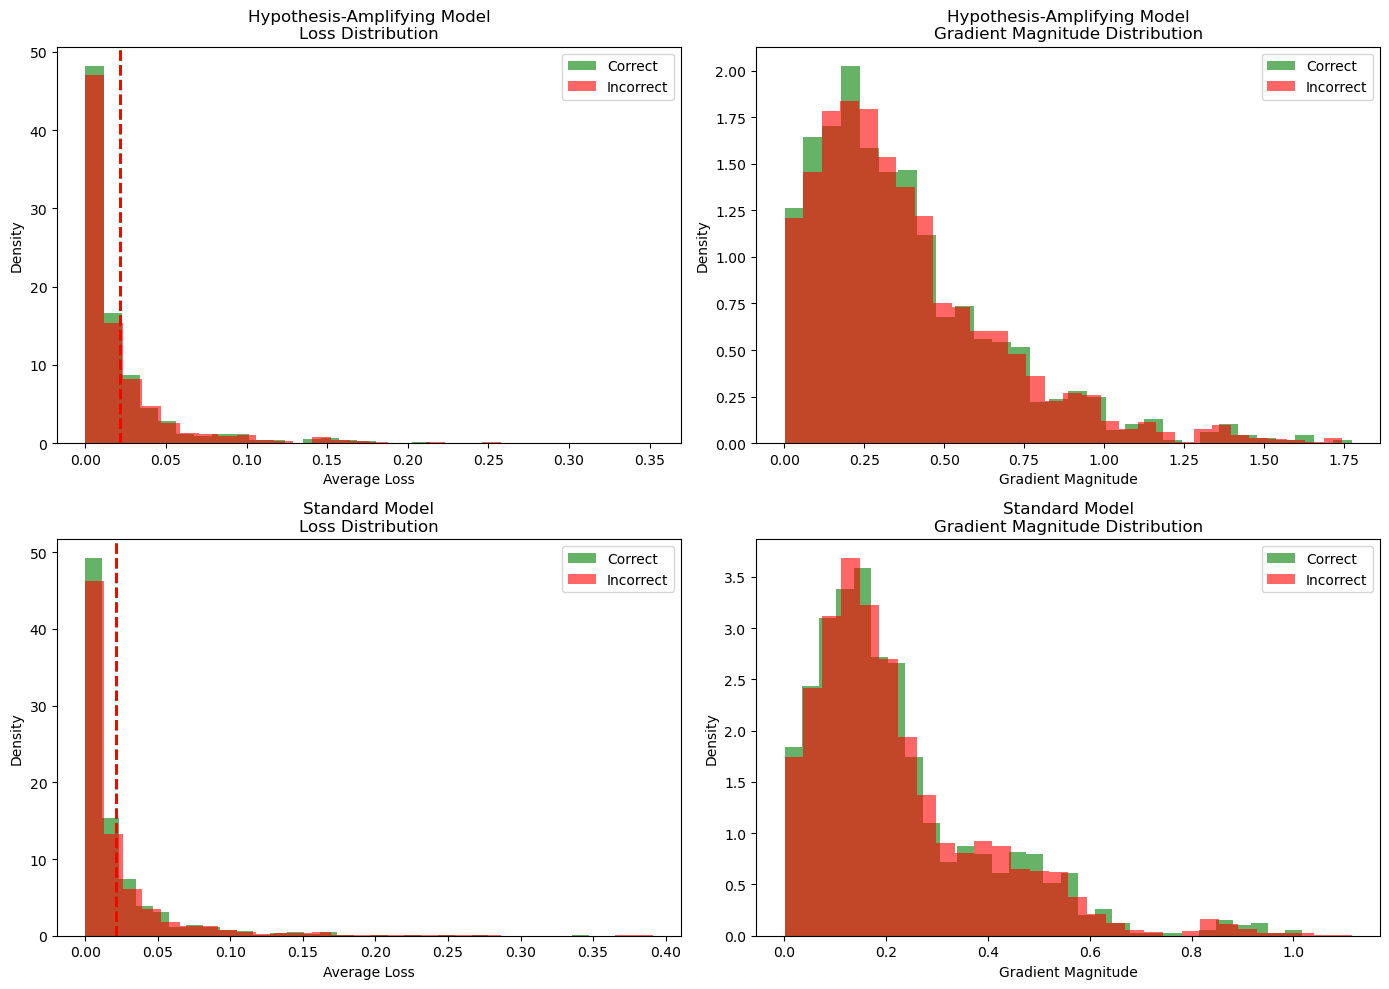

Saved to ../saved_results/Red Wine Hybrid/phase1/model_comparison.png


In [20]:
# Visualize loss distributions for both models
if not DO.lack_partial_coverage:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    for idx, (results, name) in enumerate([
        (results_amp, "Hypothesis-Amplifying Model"),
        (results_std, "Standard Model")
    ]):
        # Loss distribution
        ax1 = axes[idx, 0]
        ax1.hist(results['correct_losses'], bins=30, alpha=0.6, label='Correct', color='green', density=True)
        ax1.hist(results['incorrect_losses'], bins=30, alpha=0.6, label='Incorrect', color='red', density=True)
        ax1.axvline(np.mean(results['correct_losses']), color='green', linestyle='--', linewidth=2)
        ax1.axvline(np.mean(results['incorrect_losses']), color='red', linestyle='--', linewidth=2)
        ax1.set_xlabel('Average Loss')
        ax1.set_ylabel('Density')
        ax1.set_title(f'{name}\nLoss Distribution')
        ax1.legend()
        
        # Gradient magnitude distribution
        ax2 = axes[idx, 1]
        correct_mags = [np.linalg.norm(g) for g in results['correct_grads']]
        incorrect_mags = [np.linalg.norm(g) for g in results['incorrect_grads']]
        ax2.hist(correct_mags, bins=30, alpha=0.6, label='Correct', color='green', density=True)
        ax2.hist(incorrect_mags, bins=30, alpha=0.6, label='Incorrect', color='red', density=True)
        ax2.set_xlabel('Gradient Magnitude')
        ax2.set_ylabel('Density')
        ax2.set_title(f'{name}\nGradient Magnitude Distribution')
        ax2.legend()
    
    plt.tight_layout()
    plt.savefig(f'{results_path}/phase1/model_comparison.png', dpi=150)
    plt.show()
    print(f"Saved to {results_path}/phase1/model_comparison.png")

In [21]:
# Within-sample ranking accuracy for both models
def compute_ranking_accuracy(trainer, DO, hyp_per_sample):
    """Check if correct hypothesis has lowest loss within each sample."""
    analysis = trainer.get_hypothesis_analysis()
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    
    correct_ranked_first = 0
    correct_in_top2 = 0
    
    for sample_idx in range(n_samples):
        start = sample_idx * hyp_per_sample
        
        sample_data = []
        correct_hyp_idx = None
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in analysis:
                sample_data.append((hyp_idx, analysis[gid]['avg_loss']))
                if DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']:
                    correct_hyp_idx = hyp_idx
        
        if sample_data and correct_hyp_idx is not None:
            sample_data.sort(key=lambda x: x[1])  # Sort by loss
            ranked = [x[0] for x in sample_data]
            
            if ranked[0] == correct_hyp_idx:
                correct_ranked_first += 1
            if correct_hyp_idx in ranked[:2]:
                correct_in_top2 += 1
    
    return correct_ranked_first / n_samples, correct_in_top2 / n_samples

if not DO.lack_partial_coverage:
    print(f"\n{'='*60}")
    print("WITHIN-SAMPLE RANKING ACCURACY")
    print(f"{'='*60}")
    print(f"\nRandom baseline: {100/hyp_per_sample:.1f}% (top 1), {200/hyp_per_sample:.1f}% (top 2)")
    
    top1_amp, top2_amp = compute_ranking_accuracy(trainer_amp, DO, hyp_per_sample)
    top1_std, top2_std = compute_ranking_accuracy(trainer_std, DO, hyp_per_sample)
    
    print(f"\nHypothesis-Amplifying Model:")
    print(f"  Correct ranked #1: {top1_amp*100:.1f}%")
    print(f"  Correct in top 2:  {top2_amp*100:.1f}%")
    
    print(f"\nStandard Model:")
    print(f"  Correct ranked #1: {top1_std*100:.1f}%")
    print(f"  Correct in top 2:  {top2_std*100:.1f}%")


WITHIN-SAMPLE RANKING ACCURACY

Random baseline: 33.3% (top 1), 66.7% (top 2)

Hypothesis-Amplifying Model:
  Correct ranked #1: 38.9%
  Correct in top 2:  77.8%

Standard Model:
  Correct ranked #1: 28.3%
  Correct in top 2:  65.6%


In [22]:
# CONSTRAINED ANCHOR-BASED SELECTION WITH ADAPTIVE CONTEXT + Z-SCORE NORMALIZATION
# Uses all available information layers:
# 1. One-per-sample constraint (guarantees 1/hyp_per_sample selection)
# 2. Class-specific anchors from partial data
# 3. ADAPTIVE: gradient-only OR enriched based on anchor quality per class
# 4. Z-SCORE NORMALIZATION: ensures all classes have comparable score scales

def constrained_anchor_selection_adaptive(trainer, DO, verbose=True):
    """
    Select hypotheses using adaptive context with Z-score normalization.
    """
    # Get anchor data WITH score statistics for normalization
    anchor_data = compute_anchor_data_with_stats(trainer, DO)
    
    analysis = trainer.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    input_cols = anchor_data['input_cols']
    
    partial_sample_indices = anchor_data['partial_sample_indices']
    blacklisted_gids = anchor_data['blacklisted_gids']
    
    if verbose:
        print("="*70)
        print("CONSTRAINED ANCHOR-BASED SELECTION")
        print("(Adaptive Context + Z-Score Normalization)")
        print("="*70)
        print()
        print_adaptive_method_summary(anchor_data, hyp_per_sample)
        print_score_stats(anchor_data, hyp_per_sample)
    
    # Select one hypothesis per sample using NORMALIZED scores
    selected_gids = []
    selection_correct = 0
    class_selections = {c: 0 for c in range(hyp_per_sample)}
    class_correct = {c: 0 for c in range(hyp_per_sample)}
    
    for sample_idx in range(n_samples):
        if sample_idx in partial_sample_indices:
            continue
            
        start = sample_idx * hyp_per_sample
        best_score = -np.inf
        best_gid = None
        best_class = None
        best_is_correct = False
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in blacklisted_gids:
                continue
            if gid not in analysis or analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
            
            # NORMALIZED ADAPTIVE SCORE
            score = compute_adaptive_score_normalized(gradient, features, class_id, anchor_data)
            
            if score > best_score:
                best_score = score
                best_gid = gid
                best_class = class_id
                best_is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
        
        if best_gid is not None:
            selected_gids.append(best_gid)
            class_selections[best_class] += 1
            if best_is_correct:
                selection_correct += 1
                class_correct[best_class] += 1
    
    precision = selection_correct / len(selected_gids) if selected_gids else 0
    
    if verbose:
        print(f"\nResults:")
        print(f"  Total selected: {len(selected_gids)}")
        print(f"  Correct: {selection_correct} ({precision*100:.1f}% precision)")
        print(f"  Random baseline: 25.0%")
        print(f"\n  Per-class breakdown:")
        for c in range(hyp_per_sample):
            sel = class_selections[c]
            corr = class_correct[c]
            prec = corr/sel*100 if sel > 0 else 0
            use_enr = anchor_data['use_enriched'].get(c, False)
            method = "enriched" if use_enr else "grad-only"
            print(f"    Class {c} ({method}): {sel} selected, {corr} correct ({prec:.1f}%)")
    
    return {
        'selected_gids': selected_gids,
        'precision': precision,
        'n_correct': selection_correct,
        'class_selections': class_selections,
        'class_correct': class_correct,
        'anchor_data': anchor_data
    }

# Run adaptive selection with normalization
if not DO.lack_partial_coverage:
    selection_results = constrained_anchor_selection_adaptive(trainer_amp, DO)


CONSTRAINED ANCHOR-BASED SELECTION
(Adaptive Context + Z-Score Normalization)

Per-class method selection:
  Class 0: grad_sim=-0.992 (good) → GRADIENT-ONLY
  Class 1: grad_sim=+0.976 (poor) → ENRICHED (enriched_sim=-0.353)
  Class 2: grad_sim=-0.420 (good) → GRADIENT-ONLY

Score statistics per class (for Z-score normalization):
------------------------------------------------------------
  Class 0 (grad-only): mean=+0.129, std=1.983, range=[-2.00, 2.00]
  Class 1 (enriched): mean=-0.201, std=0.946, range=[-1.62, 1.58]
  Class 2 (grad-only): mean=-0.109, std=1.389, range=[-1.50, 1.50]

Results:
  Total selected: 1123
  Correct: 549 (48.9% precision)
  Random baseline: 25.0%

  Per-class breakdown:
    Class 0 (grad-only): 434 selected, 280 correct (64.5%)
    Class 1 (enriched): 236 selected, 98 correct (41.5%)
    Class 2 (grad-only): 453 selected, 171 correct (37.7%)


THRESHOLD PRECISION ANALYSIS (Adaptive Context)

Per-class method selection:
  Class 0: grad_sim=-0.992 (good) → GRADIENT-ONLY
  Class 1: grad_sim=+0.976 (poor) → ENRICHED (enriched_sim=-0.353)
  Class 2: grad_sim=-0.420 (good) → GRADIENT-ONLY

Precision by Top Percentile (highest scores first):
--------------------------------------------------
Top  10%:  112 samples, precision=62.5%
Top  20%:  224 samples, precision=67.9%
Top  30%:  336 samples, precision=68.5%
Top  40%:  449 samples, precision=64.1%
Top  50%:  561 samples, precision=60.2%
Top  60%:  673 samples, precision=57.8%
Top  70%:  786 samples, precision=56.1%
Top  80%:  898 samples, precision=52.9%
Top  90%: 1010 samples, precision=50.2%
Top 100%: 1123 samples, precision=48.7%

Precision by Score Bin:
--------------------------------------------------
Score -1.28--0.95:    1 samples, precision=0.0%
Score 0.36-0.69:    1 samples, precision=0.0%
Score 0.69-1.01:    1 samples, precision=100.0%
Score 1.01-1.34:   74 samples, pre

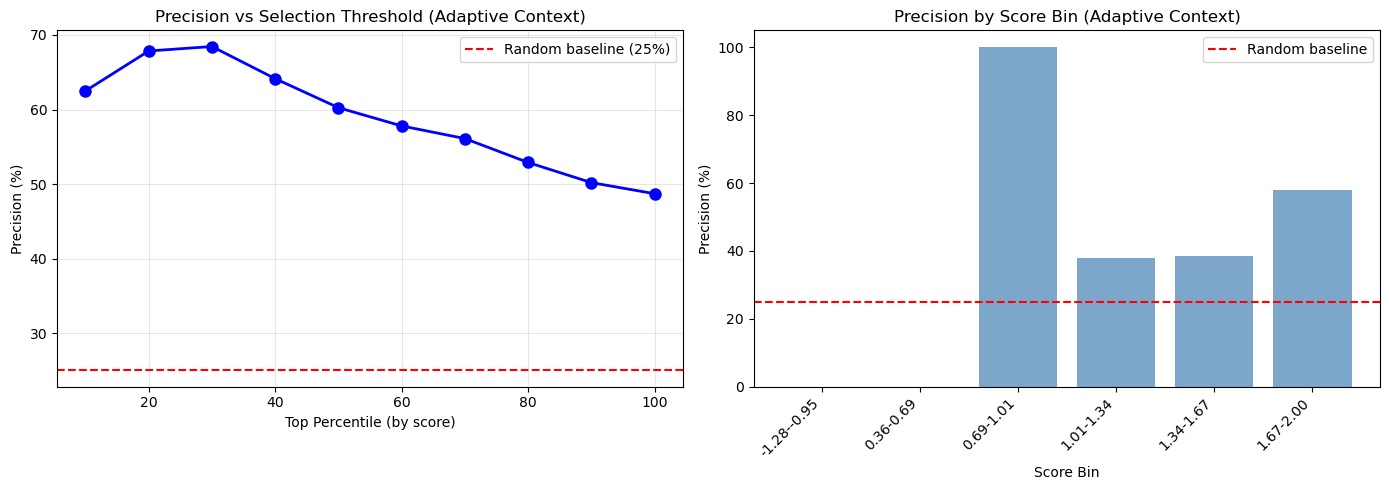

In [25]:
# THRESHOLD SELECTION ANALYSIS WITH ADAPTIVE CONTEXT
# Question: Does higher score = higher precision?
# Uses adaptive scoring: gradient-only or enriched based on anchor quality per class

def analyze_threshold_precision_adaptive(trainer, DO, verbose=True):
    """
    Analyze relationship between score threshold and precision using ADAPTIVE context.
    """
    # Get anchor data with adaptive context info
    anchor_data = compute_anchor_data(trainer, DO)
    
    analysis = trainer.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    input_cols = anchor_data['input_cols']
    
    partial_sample_indices = anchor_data['partial_sample_indices']
    blacklisted_gids = anchor_data['blacklisted_gids']
    
    # Collect ALL scores and correctness for non-partial samples
    all_selections = []  # List of (score, is_correct, sample_idx)
    
    for sample_idx in range(n_samples):
        if sample_idx in partial_sample_indices:
            continue
        
        start = sample_idx * hyp_per_sample
        best_score = -np.inf
        best_is_correct = False
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in blacklisted_gids:
                continue
            if gid not in analysis or analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
            
            # ADAPTIVE SCORE
            score = compute_adaptive_score(gradient, features, class_id, anchor_data)
            
            if score > best_score:
                best_score = score
                best_is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
        
        if best_score > -np.inf:
            all_selections.append((best_score, best_is_correct, sample_idx))
    
    # Sort by score (descending)
    all_selections.sort(key=lambda x: x[0], reverse=True)
    
    # Compute precision at different thresholds (top N%)
    results = []
    percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    
    for pct in percentiles:
        n_include = max(1, int(len(all_selections) * pct / 100))
        top_selections = all_selections[:n_include]
        n_correct = sum(1 for _, is_correct, _ in top_selections if is_correct)
        precision = n_correct / n_include
        results.append({
            'percentile': pct,
            'n_samples': n_include,
            'n_correct': n_correct,
            'precision': precision
        })
    
    # Also compute precision in score bins
    scores = [s[0] for s in all_selections]
    min_score, max_score = min(scores), max(scores)
    n_bins = 10
    bin_results = []
    
    for i in range(n_bins):
        bin_low = min_score + (max_score - min_score) * i / n_bins
        bin_high = min_score + (max_score - min_score) * (i + 1) / n_bins
        bin_selections = [(s, c) for s, c, _ in all_selections if bin_low <= s < bin_high]
        if bin_selections:
            bin_correct = sum(1 for _, c in bin_selections if c)
            bin_results.append({
                'bin': f'{bin_low:.2f}-{bin_high:.2f}',
                'n_samples': len(bin_selections),
                'precision': bin_correct / len(bin_selections)
            })
    
    if verbose:
        print("="*70)
        print("THRESHOLD PRECISION ANALYSIS (Adaptive Context)")
        print("="*70)
        print()
        print_adaptive_method_summary(anchor_data, hyp_per_sample)
        
        print("\nPrecision by Top Percentile (highest scores first):")
        print("-" * 50)
        for r in results:
            print(f"Top {r['percentile']:>3}%: {r['n_samples']:>4} samples, "
                  f"precision={r['precision']*100:.1f}%")
        
        print("\nPrecision by Score Bin:")
        print("-" * 50)
        for r in bin_results:
            print(f"Score {r['bin']}: {r['n_samples']:>4} samples, "
                  f"precision={r['precision']*100:.1f}%")
    
    return results, bin_results, all_selections, anchor_data

# Run analysis with adaptive context
if not DO.lack_partial_coverage:
    results, bin_results, all_selections, anchor_data = analyze_threshold_precision_adaptive(trainer_amp, DO)
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Precision vs Top Percentile
    ax1 = axes[0]
    pcts = [r['percentile'] for r in results]
    precs = [r['precision'] * 100 for r in results]
    ax1.plot(pcts, precs, 'bo-', linewidth=2, markersize=8)
    ax1.axhline(y=25, color='r', linestyle='--', label='Random baseline (25%)')
    ax1.set_xlabel('Top Percentile (by score)')
    ax1.set_ylabel('Precision (%)')
    ax1.set_title('Precision vs Selection Threshold (Adaptive Context)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Precision by Score Bin
    ax2 = axes[1]
    bins = [r['bin'] for r in bin_results]
    bin_precs = [r['precision'] * 100 for r in bin_results]
    ax2.bar(range(len(bins)), bin_precs, color='steelblue', alpha=0.7)
    ax2.axhline(y=25, color='r', linestyle='--', label='Random baseline')
    ax2.set_xticks(range(len(bins)))
    ax2.set_xticklabels(bins, rotation=45, ha='right')
    ax2.set_xlabel('Score Bin')
    ax2.set_ylabel('Precision (%)')
    ax2.set_title('Precision by Score Bin (Adaptive Context)')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig(f'{results_path}/phase1/threshold_precision_adaptive.png', dpi=150)
    plt.show()


In [26]:
# DIAGNOSTIC: Understanding Selection Precision with Z-SCORE NORMALIZATION
# Goal: Identify WHY precision is limited and WHERE we can improve

def diagnose_selection_precision_adaptive(trainer, DO, verbose=True):
    """
    Deep diagnostic analysis of selection precision using ADAPTIVE context
    with Z-SCORE NORMALIZATION for fair comparison across classes.
    """
    # Compute anchor data WITH score statistics
    anchor_data = compute_anchor_data_with_stats(trainer, DO)
    
    analysis = trainer.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    input_cols = anchor_data['input_cols']
    
    partial_correct_gids = anchor_data['partial_correct_gids']
    blacklisted_gids = anchor_data['blacklisted_gids']
    partial_sample_indices = anchor_data['partial_sample_indices']
    
    # Print adaptive context decision
    print("="*70)
    print("ADAPTIVE CONTEXT + Z-SCORE NORMALIZATION")
    print("="*70)
    print_adaptive_method_summary(anchor_data, hyp_per_sample)
    print_score_stats(anchor_data, hyp_per_sample)
    
    # === SELECTION WITH NORMALIZED SCORING ===
    print("\n" + "="*70)
    print("SELECTION RESULTS")
    print("="*70)
    
    # Track results
    class_selections = {c: {'selected': 0, 'correct': 0, 'true_count': 0} for c in range(hyp_per_sample)}
    all_selections = []  # (gid, score, is_correct, true_class, selected_class)
    
    for sample_idx in range(n_samples):
        if sample_idx in partial_sample_indices:
            continue
            
        start = sample_idx * hyp_per_sample
        
        # Find true class for this sample
        true_class = None
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']:
                true_class = hyp_idx
                class_selections[true_class]['true_count'] += 1
                break
        
        # Score each hypothesis using NORMALIZED adaptive method
        best_score = -np.inf
        best_gid = None
        best_class = None
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in blacklisted_gids:
                continue
            if gid not in analysis or analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
            
            # NORMALIZED ADAPTIVE SCORE
            score = compute_adaptive_score_normalized(gradient, features, class_id, anchor_data)
            
            if score > best_score:
                best_score = score
                best_gid = gid
                best_class = class_id
        
        if best_gid is not None:
            is_correct = DO.df_train_hypothesis.iloc[best_gid]['correct_hypothesis']
            class_selections[best_class]['selected'] += 1
            if is_correct:
                class_selections[best_class]['correct'] += 1
            all_selections.append((best_gid, best_score, is_correct, true_class, best_class))
    
    # === RESULTS ===
    total_selected = sum(c['selected'] for c in class_selections.values())
    total_correct = sum(c['correct'] for c in class_selections.values())
    overall_precision = total_correct / total_selected if total_selected > 0 else 0
    
    print(f"\nOverall: {total_correct}/{total_selected} correct = {overall_precision*100:.1f}% precision")
    print(f"(Random baseline: 25.0%)")
    
    print("\nPer-Class Results:")
    print("-" * 60)
    for c in range(hyp_per_sample):
        sel = class_selections[c]['selected']
        corr = class_selections[c]['correct']
        true_cnt = class_selections[c]['true_count']
        prec = corr/sel*100 if sel > 0 else 0
        use_enr = anchor_data['use_enriched'].get(c, False)
        method = "enriched" if use_enr else "grad-only"
        print(f"  Class {c} ({method}): {sel} selected, {corr} correct ({prec:.1f}% precision), {true_cnt} true samples")
    
    # === CONFUSION MATRIX ===
    print("\n" + "="*70)
    print("CONFUSION MATRIX (True vs Selected)")
    print("="*70)
    
    confusion = np.zeros((hyp_per_sample, hyp_per_sample), dtype=int)
    for _, _, _, true_class, selected_class in all_selections:
        if true_class is not None:
            confusion[true_class, selected_class] += 1
    
    print("\n      Selected →")
    print("True ↓  ", end="")
    for c in range(hyp_per_sample):
        print(f"  C{c}  ", end="")
    print()
    
    for true_c in range(hyp_per_sample):
        print(f"  C{true_c}    ", end="")
        for sel_c in range(hyp_per_sample):
            print(f" {confusion[true_c, sel_c]:4d} ", end="")
        print()
    
    return {
        'class_selections': class_selections,
        'all_selections': all_selections,
        'precision': overall_precision,
        'anchor_data': anchor_data
    }

# Run with normalized adaptive context
if not DO.lack_partial_coverage:
    results_adaptive = diagnose_selection_precision_adaptive(trainer_amp, DO)


ADAPTIVE CONTEXT + Z-SCORE NORMALIZATION
Per-class method selection:
  Class 0: grad_sim=-0.992 (good) → GRADIENT-ONLY
  Class 1: grad_sim=+0.976 (poor) → ENRICHED (enriched_sim=-0.353)
  Class 2: grad_sim=-0.420 (good) → GRADIENT-ONLY

Score statistics per class (for Z-score normalization):
------------------------------------------------------------
  Class 0 (grad-only): mean=+0.129, std=1.983, range=[-2.00, 2.00]
  Class 1 (enriched): mean=-0.201, std=0.946, range=[-1.62, 1.58]
  Class 2 (grad-only): mean=-0.109, std=1.389, range=[-1.50, 1.50]

SELECTION RESULTS

Overall: 549/1123 correct = 48.9% precision
(Random baseline: 25.0%)

Per-Class Results:
------------------------------------------------------------
  Class 0 (grad-only): 434 selected, 280 correct (64.5% precision), 473 true samples
  Class 1 (enriched): 236 selected, 98 correct (41.5% precision), 397 true samples
  Class 2 (grad-only): 453 selected, 171 correct (37.7% precision), 253 true samples

CONFUSION MATRIX (True

In [27]:
# DIAGNOSTIC: Class Selection Distribution with ADAPTIVE CONTEXT

def diagnose_class_selection_adaptive(trainer, DO):
    """
    Investigate class selection distribution with adaptive context.
    """
    # Get anchor data
    anchor_data = compute_anchor_data(trainer, DO)
    
    analysis = trainer.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    input_cols = anchor_data['input_cols']
    
    partial_sample_indices = anchor_data['partial_sample_indices']
    blacklisted_gids = anchor_data['blacklisted_gids']
    
    print("="*70)
    print("CLASS SELECTION ANALYSIS (Adaptive Context)")
    print("="*70)
    print()
    print_adaptive_method_summary(anchor_data, hyp_per_sample)
    
    # Collect scores by class
    all_scores = {c: [] for c in range(hyp_per_sample)}
    wins_by_class = {c: 0 for c in range(hyp_per_sample)}
    correct_by_class = {c: 0 for c in range(hyp_per_sample)}
    total_samples = 0
    
    for sample_idx in range(n_samples):
        if sample_idx in partial_sample_indices:
            continue
        
        start = sample_idx * hyp_per_sample
        sample_scores = []
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in blacklisted_gids:
                sample_scores.append((hyp_idx, -np.inf, False))
                continue
            if gid not in analysis or analysis[gid]['avg_gradient'] is None:
                sample_scores.append((hyp_idx, -np.inf, False))
                continue
            
            gradient = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
            
            # ADAPTIVE SCORE
            score = compute_adaptive_score(gradient, features, class_id, anchor_data)
            is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
            
            sample_scores.append((hyp_idx, score, is_correct))
            all_scores[class_id].append({'score': score, 'is_correct': is_correct})
        
        # Find winner
        winner_idx, winner_score, winner_correct = max(sample_scores, key=lambda x: x[1])
        wins_by_class[winner_idx] += 1
        if winner_correct:
            correct_by_class[winner_idx] += 1
        total_samples += 1
    
    # Print results
    print("\n" + "="*70)
    print("SELECTION DISTRIBUTION")
    print("="*70)
    
    print(f"\nTotal non-partial samples: {total_samples}")
    print("\nHow often each class is selected:")
    for c in range(hyp_per_sample):
        pct = wins_by_class[c] / total_samples * 100
        corr = correct_by_class[c]
        prec = corr / wins_by_class[c] * 100 if wins_by_class[c] > 0 else 0
        use_enr = anchor_data['use_enriched'].get(c, False)
        method = "enriched" if use_enr else "grad-only"
        print(f"  Class {c} ({method}): {wins_by_class[c]}/{total_samples} = {pct:.1f}%  (precision: {prec:.1f}%)")
    
    # Score statistics
    print("\n" + "="*70)
    print("SCORE STATISTICS BY CLASS")
    print("="*70)
    
    for c in range(hyp_per_sample):
        scores = [s['score'] for s in all_scores[c]]
        if scores:
            print(f"\nClass {c}:")
            print(f"  Score: mean={np.mean(scores):.4f}, std={np.std(scores):.4f}")
            print(f"  Range: [{min(scores):.4f}, {max(scores):.4f}]")
    
    return {
        'wins_by_class': wins_by_class,
        'correct_by_class': correct_by_class,
        'all_scores': all_scores,
        'anchor_data': anchor_data
    }

# Run diagnostic
if not DO.lack_partial_coverage:
    class_results = diagnose_class_selection_adaptive(trainer_amp, DO)


CLASS SELECTION ANALYSIS (Adaptive Context)

Per-class method selection:
  Class 0: grad_sim=-0.992 (good) → GRADIENT-ONLY
  Class 1: grad_sim=+0.976 (poor) → ENRICHED (enriched_sim=-0.353)
  Class 2: grad_sim=-0.420 (good) → GRADIENT-ONLY

SELECTION DISTRIBUTION

Total non-partial samples: 1123

How often each class is selected:
  Class 0 (grad-only): 598/1123 = 53.3%  (precision: 57.9%)
  Class 1 (enriched): 12/1123 = 1.1%  (precision: 50.0%)
  Class 2 (grad-only): 513/1123 = 45.7%  (precision: 38.0%)

SCORE STATISTICS BY CLASS

Class 0:
  Score: mean=0.1292, std=1.9830
  Range: [-1.9957, 1.9960]

Class 1:
  Score: mean=-0.2006, std=0.9462
  Range: [-1.6250, 1.5796]

Class 2:
  Score: mean=-0.1089, std=1.3893
  Range: [-1.5041, 1.4980]


In [28]:
# DIAGNOSTIC: Does adding input features as context improve anchor separation?
# Theory: Gradients alone may not distinguish correct from incorrect for Class 1
# because both produce similar gradient directions. The INPUT FEATURES should differ.
#
# BUG FIX: Previously used hypothesis value (constant within class) which dominated gradients.
# Now using actual input features (inpt_vars) which vary per sample.

def diagnose_gradient_vs_context(trainer, DO, verbose=True):
    """
    Compare anchor separation using:
    1. Gradient only
    2. Gradient + input features (actual input variables, NOT hypothesis value)
    3. Gradient + input features + loss
    """
    analysis = trainer.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    
    # Get partial data info
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    
    # Get the input feature columns (NOT hypothesis value)
    input_cols = DO.inpt_vars  # These vary per sample!
    
    print("="*70)
    print("GRADIENT vs GRADIENT+CONTEXT ANCHOR SEPARATION")
    print("="*70)
    print(f"\nUsing {len(input_cols)} input features: {input_cols}")
    
    results = {}
    
    for class_id in range(hyp_per_sample):
        class_correct_gids = [gid for gid in partial_correct_gids 
                              if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        class_incorrect_gids = [gid for gid in blacklisted_gids 
                                if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        
        if not class_correct_gids or not class_incorrect_gids:
            print(f"\nClass {class_id}: Insufficient data (correct={len(class_correct_gids)}, incorrect={len(class_incorrect_gids)})")
            continue
        
        # Collect data for correct and incorrect
        correct_grads = []
        correct_features = []
        correct_losses = []
        
        incorrect_grads = []
        incorrect_features = []
        incorrect_losses = []
        
        for gid in class_correct_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None:
                correct_grads.append(analysis[gid]['avg_gradient'])
                # Extract features as a numpy array explicitly
                feat_values = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
                correct_features.append(feat_values)
                correct_losses.append(float(analysis[gid]['avg_loss']))
        
        for gid in class_incorrect_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None:
                incorrect_grads.append(analysis[gid]['avg_gradient'])
                feat_values = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
                incorrect_features.append(feat_values)
                incorrect_losses.append(float(analysis[gid]['avg_loss']))
        
        if not correct_grads or not incorrect_grads:
            print(f"\nClass {class_id}: No valid gradients")
            continue
        
        # Convert to arrays with explicit dtype
        correct_grads = np.array(correct_grads, dtype=np.float64)
        incorrect_grads = np.array(incorrect_grads, dtype=np.float64)
        correct_features = np.array(correct_features, dtype=np.float64)
        incorrect_features = np.array(incorrect_features, dtype=np.float64)
        correct_losses = np.array(correct_losses, dtype=np.float64).reshape(-1, 1)
        incorrect_losses = np.array(incorrect_losses, dtype=np.float64).reshape(-1, 1)
        
        # Normalize features and losses to be on similar scale as gradients
        # Use the gradient norm as reference scale
        grad_norms = [np.linalg.norm(g) for g in correct_grads] + [np.linalg.norm(g) for g in incorrect_grads]
        grad_scale = float(np.mean(grad_norms))
        
        all_features = np.vstack([correct_features, incorrect_features])
        feature_mean = np.mean(all_features, axis=0).astype(np.float64)
        feature_std = np.std(all_features, axis=0).astype(np.float64) + 1e-8
        
        # Normalize features to have similar scale as gradients
        correct_features_norm = (correct_features - feature_mean) / feature_std * grad_scale
        incorrect_features_norm = (incorrect_features - feature_mean) / feature_std * grad_scale
        
        all_losses = np.vstack([correct_losses, incorrect_losses])
        loss_mean = float(np.mean(all_losses))
        loss_std = float(np.std(all_losses)) + 1e-8
        correct_losses_norm = (correct_losses - loss_mean) / loss_std * grad_scale
        incorrect_losses_norm = (incorrect_losses - loss_mean) / loss_std * grad_scale
        
        # Method 1: Gradient only
        anchor_correct_grad = np.mean(correct_grads, axis=0)
        anchor_incorrect_grad = np.mean(incorrect_grads, axis=0)
        sim_grad = float(np.dot(anchor_correct_grad, anchor_incorrect_grad) / (
            np.linalg.norm(anchor_correct_grad) * np.linalg.norm(anchor_incorrect_grad) + 1e-8))
        
        # Method 2: Gradient + input features
        correct_grad_feat = np.hstack([correct_grads, correct_features_norm])
        incorrect_grad_feat = np.hstack([incorrect_grads, incorrect_features_norm])
        anchor_correct_gf = np.mean(correct_grad_feat, axis=0)
        anchor_incorrect_gf = np.mean(incorrect_grad_feat, axis=0)
        sim_grad_feat = float(np.dot(anchor_correct_gf, anchor_incorrect_gf) / (
            np.linalg.norm(anchor_correct_gf) * np.linalg.norm(anchor_incorrect_gf) + 1e-8))
        
        # Method 3: Gradient + input features + loss
        correct_grad_feat_loss = np.hstack([correct_grads, correct_features_norm, correct_losses_norm])
        incorrect_grad_feat_loss = np.hstack([incorrect_grads, incorrect_features_norm, incorrect_losses_norm])
        anchor_correct_gfl = np.mean(correct_grad_feat_loss, axis=0)
        anchor_incorrect_gfl = np.mean(incorrect_grad_feat_loss, axis=0)
        sim_grad_feat_loss = float(np.dot(anchor_correct_gfl, anchor_incorrect_gfl) / (
            np.linalg.norm(anchor_correct_gfl) * np.linalg.norm(anchor_incorrect_gfl) + 1e-8))
        
        hyp_value = hypothesis[0][class_id]
        print(f"\nClass {class_id} (alcohol={hyp_value}):")
        print(f"  Samples: correct={len(correct_grads)}, incorrect={len(incorrect_grads)}")
        print(f"  Gradient only:             anchor_similarity = {sim_grad:.4f}")
        print(f"  Gradient + input_features: anchor_similarity = {sim_grad_feat:.4f}")
        print(f"  Gradient + features + loss: anchor_similarity = {sim_grad_feat_loss:.4f}")
        
        # Check if context helps (similarity closer to -1 is better)
        if sim_grad_feat < sim_grad:
            print(f"  → Adding input features IMPROVES separation (Δ = {sim_grad - sim_grad_feat:.4f})")
        else:
            print(f"  → Adding input features does NOT help")
        
        # Also check the actual feature differences
        print(f"  \n  Input feature statistics:")
        correct_feat_mean = np.mean(correct_features, axis=0)
        incorrect_feat_mean = np.mean(incorrect_features, axis=0)
        feat_diff = correct_feat_mean - incorrect_feat_mean
        max_diff_idx = np.argmax(np.abs(feat_diff))
        print(f"    Largest mean difference: {input_cols[max_diff_idx]} (Δ = {feat_diff[max_diff_idx]:.4f})")
        
        results[class_id] = {
            'sim_grad': sim_grad,
            'sim_grad_feat': sim_grad_feat,
            'sim_grad_feat_loss': sim_grad_feat_loss,
            'n_correct': len(correct_grads),
            'n_incorrect': len(incorrect_grads)
        }
    
    # Summary
    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    print("\nAnchor similarity closer to -1 means BETTER separation (opposite directions)")
    print("Anchor similarity close to +1 means POOR separation (same direction)")
    print("\n| Class | Grad Only | Grad+Feat | Grad+Feat+Loss | Best Method |")
    print("|-------|-----------|-----------|----------------|-------------|")
    for c, r in results.items():
        best = "Grad Only"
        best_sim = r['sim_grad']
        if r['sim_grad_feat'] < best_sim:
            best = "Grad+Feat"
            best_sim = r['sim_grad_feat']
        if r['sim_grad_feat_loss'] < best_sim:
            best = "Grad+F+L"
        print(f"|   {c}   |  {r['sim_grad']:+.3f}   |  {r['sim_grad_feat']:+.3f}   |    {r['sim_grad_feat_loss']:+.3f}      | {best:11} |")
    
    return results

# Run the diagnostic
if not DO.lack_partial_coverage:
    context_results = diagnose_gradient_vs_context(trainer_amp, DO)


GRADIENT vs GRADIENT+CONTEXT ANCHOR SEPARATION

Using 3 input features: ['volatile acidity', 'total sulfur dioxide', 'citric acid']

Class 0 (alcohol=9.4):
  Samples: correct=9, incorrect=19
  Gradient only:             anchor_similarity = -0.9922
  Gradient + input_features: anchor_similarity = -0.6219
  Gradient + features + loss: anchor_similarity = -0.6385
  → Adding input features does NOT help
  
  Input feature statistics:
    Largest mean difference: volatile acidity (Δ = 0.1078)

Class 1 (alcohol=10.5):
  Samples: correct=10, incorrect=18
  Gradient only:             anchor_similarity = 0.9762
  Gradient + input_features: anchor_similarity = -0.3102
  Gradient + features + loss: anchor_similarity = -0.3121
  → Adding input features IMPROVES separation (Δ = 1.2864)
  
  Input feature statistics:
    Largest mean difference: citric acid (Δ = 0.1276)

Class 2 (alcohol=12.0):
  Samples: correct=9, incorrect=19
  Gradient only:             anchor_similarity = -0.4201
  Gradient + i

EXPERIMENT 4: ALCOHOL DISTRIBUTION ANALYSIS

1. Alcohol Distribution in Training Data:
   Min:    0.15
   Max:    0.55
   Mean:   0.30
   Median: 0.32
   Std:    0.15

   Quantiles:
     10%: 0.15
     25%: 0.15
     50%: 0.32
     75%: 0.32
     90%: 0.55

2. Current Hypotheses: [9.4, 10.5, 12.0]

3. Samples per Hypothesis Class:
   Class 0 (alcohol= 9.40):  482 samples ( 41.9%) 
   Class 1 (alcohol=10.50):  407 samples ( 35.4%) 
   Class 2 (alcohol=12.00):  262 samples ( 22.8%) 

4. Suggested Alternative Hypotheses (based on quantiles):
   10%, 33%, 66%, 90% quantiles: [np.float64(0.15), np.float64(0.15), np.float64(0.32), np.float64(0.55)]


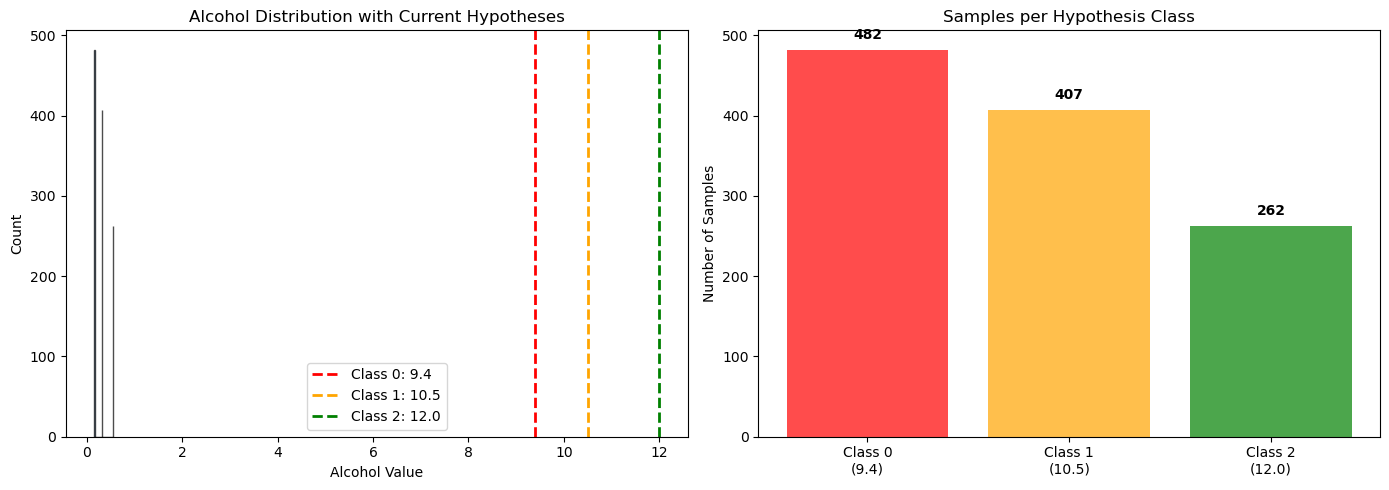


Saved to ../saved_results/Red Wine Hybrid/phase1/alcohol_distribution.png


In [29]:
# EXPERIMENT 4: Check Alcohol Distribution vs Hypotheses
# Goal: Understand if hypothesis values match the actual data distribution

if not DO.lack_partial_coverage:
    print(f"{'='*70}")
    print("EXPERIMENT 4: ALCOHOL DISTRIBUTION ANALYSIS")
    print(f"{'='*70}")
    
    # Get actual alcohol values for correct hypotheses
    correct_hyp_mask = DO.df_train_hypothesis['correct_hypothesis'] == True
    alcohol_col = f'{miss_vars[0]}_hypothesis'
    alcohol_values = DO.df_train_hypothesis[correct_hyp_mask][alcohol_col]
    
    print("\n1. Alcohol Distribution in Training Data:")
    print(f"   Min:    {alcohol_values.min():.2f}")
    print(f"   Max:    {alcohol_values.max():.2f}")
    print(f"   Mean:   {alcohol_values.mean():.2f}")
    print(f"   Median: {alcohol_values.median():.2f}")
    print(f"   Std:    {alcohol_values.std():.2f}")
    
    print(f"\n   Quantiles:")
    for q in [0.1, 0.25, 0.5, 0.75, 0.9]:
        print(f"     {int(q*100):>2}%: {alcohol_values.quantile(q):.2f}")
    
    print(f"\n2. Current Hypotheses: {hypothesis[0]}")
    
    print(f"\n3. Samples per Hypothesis Class:")
    total_samples = len(alcohol_values)
    class_counts = {}
    for class_id in range(hyp_per_sample):
        count = (DO.df_train_hypothesis[correct_hyp_mask]['hyp_class_id'] == class_id).sum()
        hyp_value = hypothesis[0][class_id]
        pct = count / total_samples * 100
        class_counts[class_id] = count
        marker = "⚠️ SPARSE!" if pct < 5 else ("⚠️ LOW" if pct < 15 else "")
        print(f"   Class {class_id} (alcohol={hyp_value:>5.2f}): {count:>4} samples ({pct:>5.1f}%) {marker}")
    
    print(f"\n4. Suggested Alternative Hypotheses (based on quantiles):")
    suggested = [
        alcohol_values.quantile(0.1),
        alcohol_values.quantile(0.33),
        alcohol_values.quantile(0.66),
        alcohol_values.quantile(0.9)
    ]
    print(f"   10%, 33%, 66%, 90% quantiles: {[round(x, 2) for x in suggested]}")
    
    # Plot distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram with hypothesis lines
    ax1 = axes[0]
    ax1.hist(alcohol_values, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
    colors = ['red', 'orange', 'green', 'purple']
    for i, hyp_val in enumerate(hypothesis[0]):
        ax1.axvline(x=hyp_val, color=colors[i], linestyle='--', linewidth=2, 
                   label=f'Class {i}: {hyp_val}')
    ax1.set_xlabel('Alcohol Value')
    ax1.set_ylabel('Count')
    ax1.set_title('Alcohol Distribution with Current Hypotheses')
    ax1.legend()
    
    # Bar chart of class counts
    ax2 = axes[1]
    bars = ax2.bar(range(hyp_per_sample), [class_counts[i] for i in range(hyp_per_sample)], 
                   color=colors, alpha=0.7)
    ax2.set_xticks(range(hyp_per_sample))
    ax2.set_xticklabels([f'Class {i}\n({hypothesis[0][i]})' for i in range(hyp_per_sample)])
    ax2.set_ylabel('Number of Samples')
    ax2.set_title('Samples per Hypothesis Class')
    
    # Add count labels on bars
    for bar, count in zip(bars, [class_counts[i] for i in range(hyp_per_sample)]):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
                str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'{results_path}/phase1/alcohol_distribution.png', dpi=150)
    plt.show()
    print(f"\nSaved to {results_path}/phase1/alcohol_distribution.png")

In [30]:
# DEBUG: Sample-Level Analysis with NORMALIZED Scores

if not DO.lack_partial_coverage:
    print(f"{'='*70}")
    print("DEBUG: NORMALIZED SCORE SAMPLE ANALYSIS")
    print(f"{'='*70}")
    
    # Get anchor data with stats
    anchor_data = compute_anchor_data_with_stats(trainer_amp, DO)
    analysis = trainer_amp.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    input_cols = anchor_data['input_cols']
    
    partial_sample_indices = anchor_data['partial_sample_indices']
    blacklisted_gids = anchor_data['blacklisted_gids']
    
    # Show method per class with stats
    print()
    print_adaptive_method_summary(anchor_data, hyp_per_sample)
    print_score_stats(anchor_data, hyp_per_sample)
    
    # Show a few sample selections
    print("\n" + "="*70)
    print("SAMPLE SELECTIONS (first 5 non-partial)")
    print("="*70)
    
    shown = 0
    for sample_idx in range(n_samples):
        if sample_idx in partial_sample_indices:
            continue
        if shown >= 5:
            break
            
        start = sample_idx * hyp_per_sample
        
        # Find true class
        true_class = None
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']:
                true_class = hyp_idx
                break
        
        print(f"\nSample {sample_idx} (True class: {true_class}):")
        
        scores = []
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in blacklisted_gids:
                scores.append((hyp_idx, -np.inf, -np.inf))
                continue
            if gid not in analysis or analysis[gid]['avg_gradient'] is None:
                scores.append((hyp_idx, -np.inf, -np.inf))
                continue
            
            gradient = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
            
            raw_score = compute_adaptive_score(gradient, features, class_id, anchor_data)
            norm_score = compute_adaptive_score_normalized(gradient, features, class_id, anchor_data)
            scores.append((hyp_idx, norm_score, raw_score))
        
        # Sort by NORMALIZED score
        sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
        winner = sorted_scores[0][0]
        
        for hyp_idx, norm_score, raw_score in sorted_scores:
            use_enr = anchor_data['use_enriched'].get(hyp_idx, False)
            method = "enr" if use_enr else "grd"
            marker = ""
            if hyp_idx == true_class:
                marker = " ← TRUE"
            if hyp_idx == winner:
                marker += " ← SELECTED"
            print(f"  Class {hyp_idx} ({method}): norm={norm_score:+.3f} (raw={raw_score:+.3f}){marker}")
        
        shown += 1


DEBUG: NORMALIZED SCORE SAMPLE ANALYSIS

Per-class method selection:
  Class 0: grad_sim=-0.992 (good) → GRADIENT-ONLY
  Class 1: grad_sim=+0.976 (poor) → ENRICHED (enriched_sim=-0.353)
  Class 2: grad_sim=-0.420 (good) → GRADIENT-ONLY

Score statistics per class (for Z-score normalization):
------------------------------------------------------------
  Class 0 (grad-only): mean=+0.129, std=1.983, range=[-2.00, 2.00]
  Class 1 (enriched): mean=-0.201, std=0.946, range=[-1.62, 1.58]
  Class 2 (grad-only): mean=-0.109, std=1.389, range=[-1.50, 1.50]

SAMPLE SELECTIONS (first 5 non-partial)

Sample 0 (True class: 1):
  Class 2 (grd): norm=+1.097 (raw=+1.415) ← SELECTED
  Class 1 (enr): norm=+0.044 (raw=-0.159) ← TRUE
  Class 0 (grd): norm=-1.070 (raw=-1.993)

Sample 1 (True class: 0):
  Class 0 (grd): norm=+0.936 (raw=+1.986) ← TRUE ← SELECTED
  Class 2 (grd): norm=-0.858 (raw=-1.301)
  Class 1 (enr): norm=-0.900 (raw=-1.053)

Sample 2 (True class: 2):
  Class 2 (grd): norm=+1.133 (raw=+1

In [39]:
# =============================================================================
# IDEA 1: CLASS PRIOR CORRECTION + ADAPTIVE CONTEXT + Z-SCORE NORMALIZATION
# =============================================================================
# Problem: We're selecting 40% Class 2 when truth is only 22.5%
# Solution: Add log-prior penalty to adjust scores toward true distribution
# 
# This version uses:
# - Adaptive context (gradient-only or enriched based on anchor quality)
# - Z-score normalization (comparable score scales across classes)
# - Class prior correction (penalize over-represented classes)

import numpy as np

def selection_with_prior_correction_adaptive(trainer, DO, prior_weight=1.0, verbose=True):
    """
    Select hypotheses using:
    1. Adaptive context (gradient-only or enriched per class)
    2. Z-score normalization 
    3. Class prior correction
    
    final_score = normalized_adaptive_score + prior_weight * log(true_prior / uniform_prior)
    """
    # Get anchor data WITH score statistics for normalization
    anchor_data = compute_anchor_data_with_stats(trainer, DO)
    
    analysis = trainer.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    input_cols = anchor_data['input_cols']
    
    partial_sample_indices = anchor_data['partial_sample_indices']
    blacklisted_gids = anchor_data['blacklisted_gids']
    
    # Compute TRUE class distribution from known correct hypotheses
    correct_mask = DO.df_train_hypothesis['correct_hypothesis'] == True
    true_class_counts = DO.df_train_hypothesis[correct_mask]['hyp_class_id'].value_counts().sort_index()
    true_priors = (true_class_counts / true_class_counts.sum()).to_dict()
    
    # Uniform prior for comparison
    uniform_prior = 1.0 / hyp_per_sample
    
    # Compute log-prior adjustment per class
    # Positive for under-represented classes, negative for over-represented
    prior_adjustment = {}
    for c in range(hyp_per_sample):
        prior_adjustment[c] = np.log(true_priors.get(c, uniform_prior) / uniform_prior)
    
    if verbose:
        print("="*70)
        print("CLASS PRIOR CORRECTION + ADAPTIVE CONTEXT + Z-SCORE NORMALIZATION")
        print("="*70)
        print(f"\nPrior weight: {prior_weight}")
        print(f"\nTrue class distribution and adjustments:")
        for c in range(hyp_per_sample):
            use_enr = anchor_data['use_enriched'].get(c, False)
            method = "enriched" if use_enr else "grad-only"
            print(f"  Class {c} ({method}): {true_priors.get(c, 0)*100:.1f}% → prior adj: {prior_adjustment[c]:+.3f}")
        
        print_adaptive_method_summary(anchor_data, hyp_per_sample)
        print_score_stats(anchor_data, hyp_per_sample)
    
    # Selection with adaptive scoring + prior correction
    selected_gids = []
    selection_correct = 0
    class_selections = {c: 0 for c in range(hyp_per_sample)}
    class_correct_sel = {c: 0 for c in range(hyp_per_sample)}
    
    # Track for confusion matrix
    confusion = {true_c: {sel_c: 0 for sel_c in range(hyp_per_sample)} for true_c in range(hyp_per_sample)}
    
    for sample_idx in range(n_samples):
        if sample_idx in partial_sample_indices:
            continue
        
        start = sample_idx * hyp_per_sample
        best_final_score = -np.inf
        best_gid = None
        best_class = None
        best_is_correct = False
        
        # Track true class for this sample
        true_class = None
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in blacklisted_gids:
                continue
            if gid not in analysis or analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
            features = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
            
            if is_correct:
                true_class = class_id
            
            # Compute NORMALIZED ADAPTIVE score
            normalized_score = compute_adaptive_score_normalized(gradient, features, class_id, anchor_data)
            
            # Apply prior correction
            final_score = normalized_score + prior_weight * prior_adjustment[class_id]
            
            if final_score > best_final_score:
                best_final_score = final_score
                best_gid = gid
                best_class = class_id
                best_is_correct = is_correct
        
        if best_gid is not None:
            selected_gids.append(best_gid)
            class_selections[best_class] += 1
            if best_is_correct:
                selection_correct += 1
                class_correct_sel[best_class] += 1
            
            # Update confusion matrix
            if true_class is not None:
                confusion[true_class][best_class] += 1
    
    precision = selection_correct / len(selected_gids) if selected_gids else 0
    
    if verbose:
        print(f"\n{'='*70}")
        print("RESULTS")
        print("="*70)
        print(f"\n  Total selected: {len(selected_gids)}")
        print(f"  Correct: {selection_correct} ({precision*100:.1f}% precision)")
        print(f"  Random baseline: {100/hyp_per_sample:.1f}%")
        print(f"\n  Per-class breakdown:")
        for c in range(hyp_per_sample):
            sel = class_selections[c]
            corr = class_correct_sel[c]
            prec = corr/sel*100 if sel > 0 else 0
            true_pct = true_priors.get(c, 0) * 100
            sel_pct = sel / len(selected_gids) * 100 if selected_gids else 0
            use_enr = anchor_data['use_enriched'].get(c, False)
            method = "enriched" if use_enr else "grad-only"
            print(f"    Class {c} ({method}): {sel} selected ({sel_pct:.1f}%), {corr} correct ({prec:.1f}% prec) | True: {true_pct:.1f}%")
        
        # Print confusion matrix
        print(f"\n{'='*70}")
        print("CONFUSION MATRIX (True vs Selected)")
        print("="*70)
        print(f"\n      Selected →")
        header = "True ↓ " + "".join([f"   C{c}  " for c in range(hyp_per_sample)])
        print(header)
        for true_c in range(hyp_per_sample):
            row = f"  C{true_c}   "
            for sel_c in range(hyp_per_sample):
                row += f" {confusion[true_c][sel_c]:>5} "
            print(row)
    
    return {
        'precision': precision,
        'selected_gids': selected_gids,
        'class_selections': class_selections,
        'class_correct': class_correct_sel,
        'prior_adjustment': prior_adjustment,
        'confusion': confusion
    }

# Run the test with different prior weights
if not DO.lack_partial_coverage:
    print("\n" + "="*70)
    print("TESTING DIFFERENT PRIOR WEIGHTS")
    print("="*70 + "\n")
    
    for weight in [0.0, 0.5, 1.0, 1.5, 2.0]:
        results = selection_with_prior_correction_adaptive(trainer_amp, DO, prior_weight=weight, verbose=(weight==1.0))
        if weight != 1.0:
            print(f"  Prior weight={weight}: {results['precision']*100:.1f}% precision")


TESTING DIFFERENT PRIOR WEIGHTS

  Prior weight=0.0: 48.9% precision
  Prior weight=0.5: 50.1% precision
CLASS PRIOR CORRECTION + ADAPTIVE CONTEXT + Z-SCORE NORMALIZATION

Prior weight: 1.0

True class distribution and adjustments:
  Class 0 (grad-only): 41.9% → prior adj: +0.228
  Class 1 (enriched): 35.4% → prior adj: +0.059
  Class 2 (grad-only): 22.8% → prior adj: -0.381
Per-class method selection:
  Class 0: grad_sim=-0.992 (good) → GRADIENT-ONLY
  Class 1: grad_sim=+0.976 (poor) → ENRICHED (enriched_sim=-0.353)
  Class 2: grad_sim=-0.420 (good) → GRADIENT-ONLY

Score statistics per class (for Z-score normalization):
------------------------------------------------------------
  Class 0 (grad-only): mean=+0.129, std=1.983, range=[-2.00, 2.00]
  Class 1 (enriched): mean=-0.201, std=0.946, range=[-1.62, 1.58]
  Class 2 (grad-only): mean=-0.109, std=1.389, range=[-1.50, 1.50]

RESULTS

  Total selected: 1123
  Correct: 550 (49.0% precision)
  Random baseline: 33.3%

  Per-class brea

In [38]:
# =============================================================================
# IDEA 6: GRADIENT TRAJECTORY / STABILITY
# =============================================================================
# Hypothesis: Correct hypotheses have more STABLE gradients over training epochs
# - Correct: gradient direction stays consistent as model learns
# - Incorrect: gradient direction may fluctuate as model struggles

import numpy as np

def compute_gradient_stability(trainer, DO, verbose=True):
    """
    Analyze gradient stability across training epochs.
    
    Metrics:
    1. Direction stability: Average cosine similarity between consecutive epoch gradients
    2. Magnitude stability: Coefficient of variation of gradient magnitudes
    3. Final direction alignment: How aligned is final gradient with average direction
    """
    hyp_per_sample = DO.num_hyp_comb
    
    # Access raw gradient history from trainer
    gradient_history = trainer.gradient_history
    
    stability_metrics = {}
    
    for gid, grad_list in gradient_history.items():
        if len(grad_list) < 2:
            continue
        
        grads = np.array(grad_list)
        n_epochs = len(grads)
        
        # 1. Direction stability: cosine similarity between consecutive epochs
        direction_sims = []
        for i in range(n_epochs - 1):
            g1, g2 = grads[i], grads[i+1]
            norm1, norm2 = np.linalg.norm(g1), np.linalg.norm(g2)
            if norm1 > 1e-8 and norm2 > 1e-8:
                sim = np.dot(g1, g2) / (norm1 * norm2)
                direction_sims.append(sim)
        
        direction_stability = np.mean(direction_sims) if direction_sims else 0.0
        
        # 2. Magnitude stability: coefficient of variation (std/mean)
        magnitudes = np.linalg.norm(grads, axis=1)
        magnitude_cv = np.std(magnitudes) / (np.mean(magnitudes) + 1e-8)
        magnitude_stability = 1.0 / (1.0 + magnitude_cv)  # Higher = more stable
        
        # 3. Final alignment: how aligned is final gradient with average
        avg_grad = np.mean(grads, axis=0)
        final_grad = grads[-1]
        avg_norm, final_norm = np.linalg.norm(avg_grad), np.linalg.norm(final_grad)
        if avg_norm > 1e-8 and final_norm > 1e-8:
            final_alignment = np.dot(avg_grad, final_grad) / (avg_norm * final_norm)
        else:
            final_alignment = 0.0
        
        stability_metrics[gid] = {
            'direction_stability': direction_stability,
            'magnitude_stability': magnitude_stability,
            'final_alignment': final_alignment,
            'combined_stability': (direction_stability + magnitude_stability + final_alignment) / 3
        }
    
    # Analyze by correctness
    correct_stabilities = {'direction': [], 'magnitude': [], 'final': [], 'combined': []}
    incorrect_stabilities = {'direction': [], 'magnitude': [], 'final': [], 'combined': []}
    
    for gid, metrics in stability_metrics.items():
        is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
        target = correct_stabilities if is_correct else incorrect_stabilities
        target['direction'].append(metrics['direction_stability'])
        target['magnitude'].append(metrics['magnitude_stability'])
        target['final'].append(metrics['final_alignment'])
        target['combined'].append(metrics['combined_stability'])
    
    if verbose:
        print("="*70)
        print("GRADIENT STABILITY ANALYSIS")
        print("="*70)
        print(f"\nSamples analyzed: {len(correct_stabilities['direction'])} correct, {len(incorrect_stabilities['direction'])} incorrect")
        
        print(f"\n{'Metric':<25} {'Correct':<15} {'Incorrect':<15} {'Diff':<10} {'Signal?'}")
        print("-"*70)
        
        for metric_name in ['direction', 'magnitude', 'final', 'combined']:
            corr_mean = np.mean(correct_stabilities[metric_name])
            incorr_mean = np.mean(incorrect_stabilities[metric_name])
            diff = corr_mean - incorr_mean
            signal = "✓ YES" if abs(diff) > 0.02 else "✗ weak"
            print(f"{metric_name + ' stability':<25} {corr_mean:>10.4f}     {incorr_mean:>10.4f}     {diff:>+.4f}    {signal}")
    
    return stability_metrics, correct_stabilities, incorrect_stabilities


def selection_with_stability(trainer, DO, stability_weight=0.5, verbose=True):
    """
    Select hypotheses using gradient scores + stability bonus.
    
    final_score = gradient_score + stability_weight * stability_score
    """
    # First compute stability metrics
    stability_metrics, correct_stab, incorrect_stab = compute_gradient_stability(trainer, DO, verbose=verbose)
    
    analysis = trainer.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    
    # Get partial data info
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    # Compute anchors
    anchor_correct = {}
    anchor_incorrect = {}
    
    for class_id in range(hyp_per_sample):
        class_correct = [gid for gid in partial_correct_gids 
                        if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        class_incorrect = [gid for gid in blacklisted_gids 
                          if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        
        if class_correct:
            grads = [analysis[gid]['avg_gradient'] for gid in class_correct 
                    if gid in analysis and analysis[gid]['avg_gradient'] is not None]
            anchor_correct[class_id] = np.mean(grads, axis=0) if grads else None
        
        if class_incorrect:
            grads = [analysis[gid]['avg_gradient'] for gid in class_incorrect 
                    if gid in analysis and analysis[gid]['avg_gradient'] is not None]
            anchor_incorrect[class_id] = np.mean(grads, axis=0) if grads else None
    
    # Selection with stability
    selected_gids = []
    selection_correct = 0
    class_selections = {c: 0 for c in range(hyp_per_sample)}
    class_correct_sel = {c: 0 for c in range(hyp_per_sample)}
    
    for sample_idx in range(n_samples):
        if sample_idx in partial_sample_indices:
            continue
        
        start = sample_idx * hyp_per_sample
        best_final_score = -np.inf
        best_gid = None
        best_class = None
        best_is_correct = False
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in blacklisted_gids:
                continue
            if gid not in analysis or analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
            
            # Compute gradient score
            anchor_c = anchor_correct.get(class_id)
            anchor_i = anchor_incorrect.get(class_id)
            
            if anchor_c is None:
                grad_score = 0.0
            else:
                sim_c = np.dot(gradient, anchor_c) / (np.linalg.norm(gradient) * np.linalg.norm(anchor_c) + 1e-8)
                if anchor_i is not None:
                    sim_i = np.dot(gradient, anchor_i) / (np.linalg.norm(gradient) * np.linalg.norm(anchor_i) + 1e-8)
                else:
                    sim_i = 0.0
                grad_score = sim_c - sim_i
            
            # Get stability score
            stab = stability_metrics.get(gid, {})
            stability_score = stab.get('combined_stability', 0.0)
            
            # Combined score
            final_score = grad_score + stability_weight * stability_score
            
            if final_score > best_final_score:
                best_final_score = final_score
                best_gid = gid
                best_class = class_id
                best_is_correct = is_correct
        
        if best_gid is not None:
            selected_gids.append(best_gid)
            class_selections[best_class] += 1
            if best_is_correct:
                selection_correct += 1
                class_correct_sel[best_class] += 1
    
    precision = selection_correct / len(selected_gids) if selected_gids else 0
    
    if verbose:
        print(f"\n{'='*70}")
        print(f"SELECTION WITH STABILITY (weight={stability_weight})")
        print("="*70)
        print(f"\nResults:")
        print(f"  Total selected: {len(selected_gids)}")
        print(f"  Correct: {selection_correct} ({precision*100:.1f}% precision)")
        print(f"  Random baseline: {100/hyp_per_sample:.1f}%")
        print(f"\n  Per-class breakdown:")
        for c in range(hyp_per_sample):
            sel = class_selections[c]
            corr = class_correct_sel[c]
            prec = corr/sel*100 if sel > 0 else 0
            sel_pct = sel / len(selected_gids) * 100 if selected_gids else 0
            print(f"    Class {c}: {sel} selected ({sel_pct:.1f}%), {corr} correct ({prec:.1f}% prec)")
    
    return {
        'precision': precision,
        'selected_gids': selected_gids,
        'class_selections': class_selections,
        'stability_metrics': stability_metrics
    }

# Run the tests
if not DO.lack_partial_coverage:
    # First, just analyze stability (is there a signal?)
    print("\n" + "="*70)
    print("PART 1: STABILITY ANALYSIS - Is there a signal?")
    print("="*70 + "\n")
    
    # Test different stability weights
    print("\n" + "="*70)
    print("PART 2: SELECTION WITH STABILITY")
    print("="*70 + "\n")
    
    for weight in [0.0, 0.25, 0.5, 1.0]:
        results_stab = selection_with_stability(trainer_amp, DO, stability_weight=weight, verbose=(weight==0.5))
        if weight != 0.5:
            print(f"  Stability weight={weight}: {results_stab['precision']*100:.1f}% precision")


PART 1: STABILITY ANALYSIS - Is there a signal?


PART 2: SELECTION WITH STABILITY

  Stability weight=0.0: 48.8% precision
  Stability weight=0.25: 48.8% precision
GRADIENT STABILITY ANALYSIS

Samples analyzed: 1151 correct, 2302 incorrect

Metric                    Correct         Incorrect       Diff       Signal?
----------------------------------------------------------------------
direction stability           0.9569         0.9597     -0.0028    ✗ weak
magnitude stability           0.8756         0.8761     -0.0005    ✗ weak
final stability               0.9790         0.9774     +0.0016    ✗ weak
combined stability            0.9372         0.9377     -0.0005    ✗ weak

SELECTION WITH STABILITY (weight=0.5)

Results:
  Total selected: 1123
  Correct: 548 (48.8% precision)
  Random baseline: 33.3%

  Per-class breakdown:
    Class 0: 598 selected (53.3%), 346 correct (57.9% prec)
    Class 1: 11 selected (1.0%), 6 correct (54.5% prec)
    Class 2: 514 selected (45.8%), 196 corr

# PHASE 1.5: Train on Partial Data + Constrained Anchor Selections
# Test across 15 random states to validate the approach

In [31]:
# PHASE 1.5: Train on Partial Data + Constrained Anchor Selections
# Test across 15 random states to validate the approach

def run_hybrid_experiment(rand_state, phase1_epochs=30, phase2_epochs=200, 
                          use_trajectory=False, partial_weight=2, top_percentile=100,
                          verbose=False):
    """
    Run full hybrid pipeline:
    1. Phase 1: Unbiased training to get gradients
    2. Constrained anchor selection (with blacklist enforcement)
    3. Filter to top N% by score (threshold selection)
    4. Train final model on partial + selected hypotheses (partial weighted)
    5. Evaluate on test set
    
    Args:
        partial_weight: How many times to duplicate partial data (default 2x)
        top_percentile: Only include top N% of selections by score (default 100 = all)
    """
    set_to_deterministic(rand_state)
    
    # Initialize data
    DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                      partial_perc, rand_state, device='cpu')
    DO.problem_type = 'regression'
    
    if DO.lack_partial_coverage:
        return None
    
    # Phase 1: Train amplified model on all hypotheses
    phase1_dataset = Phase1Dataset(DO)
    phase1_dataloader = torch.utils.data.DataLoader(
        phase1_dataset, batch_size=batch_size, shuffle=True
    )
    
    input_size = phase1_dataset.inputs.shape[1]
    model_p1 = HypothesisAmplifyingModel(
        n_shared_features=len(inpt_vars),
        n_hypothesis_features=1,
        shared_hidden=16, hypothesis_hidden=32, final_hidden=32,
        output_size=output_size
    )
    
    trainer = Phase1Trainer(DO, model_p1, lr=lr)
    
    for epoch in range(phase1_epochs):
        track = epoch >= (phase1_epochs - phase1_analysis_epochs)
        trainer.train_epoch(phase1_dataloader, epoch, track_data=track)
    
    # === CRITICAL: Identify partial data samples and blacklisted hypotheses ===
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    
    # Get partial data info
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    
    # BLACKLIST: Known incorrect hypotheses from partial data - NEVER select these
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    
    # Identify which samples are partial (have known correct hypothesis)
    partial_sample_indices = set()
    for gid in partial_correct_gids:
        sample_idx = gid // hyp_per_sample
        partial_sample_indices.add(sample_idx)
    
    # === Constrained anchor selection WITH blacklist enforcement ===
    analysis = trainer.get_hypothesis_analysis()
    
    # Compute anchors from partial data
    anchor_correct = {}
    anchor_incorrect = {}
    
    for class_id in range(hyp_per_sample):
        class_correct = [gid for gid in partial_correct_gids 
                        if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        if class_correct:
            grads = [analysis[gid]['avg_gradient'] for gid in class_correct 
                    if gid in analysis and analysis[gid]['avg_gradient'] is not None]
            anchor_correct[class_id] = np.mean(grads, axis=0) if grads else None
        else:
            anchor_correct[class_id] = None

        class_incorrect = [gid for gid in blacklisted_gids 
                          if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        if class_incorrect:
            grads = [analysis[gid]['avg_gradient'] for gid in class_incorrect 
                    if gid in analysis and analysis[gid]['avg_gradient'] is not None]
            anchor_incorrect[class_id] = np.mean(grads, axis=0) if grads else None
        else:
            anchor_incorrect[class_id] = None
    
    # Compute anchor similarity for anchor-aware scoring
    anchor_similarity = {}
    for class_id in range(hyp_per_sample):
        if anchor_correct.get(class_id) is not None and anchor_incorrect.get(class_id) is not None:
            anchor_similarity[class_id] = np.dot(anchor_correct[class_id], anchor_incorrect[class_id]) / (
                np.linalg.norm(anchor_correct[class_id]) * np.linalg.norm(anchor_incorrect[class_id]) + 1e-8)
        else:
            anchor_similarity[class_id] = 0

    # === Select hypotheses with scores for threshold filtering ===
    all_selections = []  # (gid, score, is_correct, sample_idx)
    
    for sample_idx in range(n_samples):
        start = sample_idx * hyp_per_sample
        
        # For partial samples, use KNOWN correct hypothesis (always include, no scoring)
        if sample_idx in partial_sample_indices:
            for hyp_idx in range(hyp_per_sample):
                gid = start + hyp_idx
                if gid in partial_correct_gids:
                    # Give partial data a very high score so they're always included
                    all_selections.append((gid, float('inf'), True, sample_idx, True))  # is_partial=True
                    break
            continue
        
        # For non-partial samples, use gradient-based selection
        best_score = -np.inf
        best_gid = None
        best_is_correct = False
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            
            if gid in blacklisted_gids:
                continue
                
            if gid not in analysis or analysis[gid]['avg_gradient'] is None:
                continue

            gradient = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']

            score = 0
            if anchor_correct.get(class_id) is not None:
                sim_correct = np.dot(gradient, anchor_correct[class_id]) / (
                    np.linalg.norm(gradient) * np.linalg.norm(anchor_correct[class_id]) + 1e-8)
                score += sim_correct

            if anchor_incorrect.get(class_id) is not None:
                sim_incorrect = np.dot(gradient, anchor_incorrect[class_id]) / (
                    np.linalg.norm(gradient) * np.linalg.norm(anchor_incorrect[class_id]) + 1e-8)


            if score > best_score:
                best_score = score
                best_gid = gid
                best_is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']

        if best_gid is not None:
            all_selections.append((best_gid, best_score, best_is_correct, sample_idx, False))  # is_partial=False
    
    # === Apply threshold: keep only top N% by score (partial always included) ===
    partial_selections = [s for s in all_selections if s[4]]  # is_partial=True
    non_partial_selections = [s for s in all_selections if not s[4]]
    
    # Sort non-partial by score (descending) and take top N%
    non_partial_selections.sort(key=lambda x: x[1], reverse=True)
    n_keep = max(1, int(len(non_partial_selections) * top_percentile / 100))
    top_selections = non_partial_selections[:n_keep]
    
    # Combine: all partial + top N% of non-partial
    final_selections = partial_selections + top_selections
    
    # Calculate precision on the selected non-partial samples
    n_correct_selected = sum(1 for s in top_selections if s[2])
    selection_precision = n_correct_selected / len(top_selections) if top_selections else 0
    
    # === Build training set with partial data weighting ===
    input_cols = DO.inpt_vars + [f'{DO.miss_vars[0]}_hypothesis']
    
    partial_gids = [s[0] for s in partial_selections]
    selected_gids = [s[0] for s in top_selections]
    
    # Weight partial data by duplicating it
    weighted_gids = partial_gids * partial_weight + selected_gids
    
    train_inputs = torch.tensor(
        DO.df_train_hypothesis.iloc[weighted_gids][input_cols].values,
        dtype=torch.float32
    )
    train_targets = torch.tensor(
        DO.df_train_hypothesis.iloc[weighted_gids][DO.target_vars].values,
        dtype=torch.float32
    )
    
    if verbose:
        print(f"Seed {rand_state}: {len(partial_gids)} partial x{partial_weight} + "
              f"{len(selected_gids)} selected (top {top_percentile}%), "
              f"precision={selection_precision*100:.1f}%")
    
    # Phase 2: Train final model on selected data
    train_dataset = torch.utils.data.TensorDataset(train_inputs, train_targets)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=min(64, len(train_inputs)), shuffle=True)
    
    model_final = StandardModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
    optimizer = torch.optim.Adam(model_final.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    best_val_loss = float('inf')
    best_state = None
    
    val_inputs = torch.tensor(DO.full_val_input, dtype=torch.float32)
    val_targets = DO.val_outcomes_tensor
    
    for epoch in range(phase2_epochs):
        model_final.train()
        for batch_inputs, batch_targets in train_loader:
            optimizer.zero_grad()
            pred = model_final(batch_inputs)
            loss = criterion(pred, batch_targets)
            loss.backward()
            optimizer.step()
        
        model_final.eval()
        with torch.no_grad():
            val_pred = model_final(val_inputs)
            val_loss = criterion(val_pred, val_targets).item()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model_final.state_dict().copy()
    
    model_final.load_state_dict(best_state)
    model_final.eval()
    
    test_inputs = DO.full_test_input_tensor
    test_targets = DO.df_test[target_vars].values
    
    with torch.no_grad():
        test_pred = model_final(test_inputs).numpy()
    
    r2_hybrid = r2_score(test_targets, test_pred)
    
    return {
        'rand_state': rand_state,
        'selection_precision': selection_precision,
        'n_training_samples': len(weighted_gids),
        'n_partial': len(partial_gids),
        'n_selected': len(selected_gids),
        'top_percentile': top_percentile,
        'r2': r2_hybrid
    }


def run_baseline_experiment(rand_state, use_info, num_epochs=200, baseline_lr=0.002, baseline_dropout=0.1):
    """
    Run baseline experiment for comparison.
    
    NOTE: Uses Wine.ipynb parameters:
    - 200 epochs (4x amplification for small datasets)
    - lr=0.002
    - dropout=0.1
    """
    set_to_deterministic(rand_state)
    
    DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                      partial_perc, rand_state, device='cpu')
    DO.problem_type = 'regression'
    
    if DO.lack_partial_coverage:
        return None
    
    AM = AlgoModulators(DO, lr=baseline_lr, nu=0.1, normalize_grads_contx=False,
                       use_context=True, freqperc_cutoff=0.25)
    
    dataloader = DO.prep_dataloader(use_info, batch_size)
    model = initialize_model(DO, dataloader, hidden_size, rand_state, dropout=baseline_dropout)
    
    TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size,
                                 rand_state, results_path, final_analysis=False)
    TVM.train_model(DO, AM, model, final_analysis=False)
    
    model.load_state_dict(torch.load(TVM.weights_save_path))
    model.eval()
    
    if use_info in ['use hypothesis', 'partial info', 'full info']:
        test_pred = model(DO.full_test_input_tensor)
    else:
        test_pred = model(DO.known_test_input_tensor)
    
    test_true = DO.df_test[target_vars].values
    r2 = r2_score(test_true, test_pred.detach().numpy())
    
    return {'rand_state': rand_state, 'r2': r2}


print("Experiment functions defined.")
print("NEW: top_percentile parameter - only include top N% of selections by score")

Experiment functions defined.
NEW: top_percentile parameter - only include top N% of selections by score


In [47]:
# =============================================================================
# EXPERIMENT: Optimal Training Epochs vs Analysis Epochs
# =============================================================================
# Question: Which gradient configuration produces best separation?
# - Model trained for 15, 30, or 60 epochs
# - Looking at last 5, 10, or 20 gradients for averaging
#
# Fixed parameters: top_percentile=5, partial_weight=3, 15 random states

import numpy as np
from tqdm import tqdm

def run_hybrid_experiment_configurable(rand_state, phase1_epochs, phase1_analysis_epochs,
                                        phase2_epochs=200, partial_weight=3, top_percentile=5,
                                        verbose=False):
    """
    Run hybrid experiment with configurable phase1 training and analysis epochs.
    Matches the original run_hybrid_experiment implementation.
    """
    set_to_deterministic(rand_state)
    
    # Initialize data
    DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                      partial_perc, rand_state, device='cpu')
    DO.problem_type = 'regression'
    
    if DO.lack_partial_coverage:
        return None
    
    # Phase 1: Train amplified model
    phase1_dataset = Phase1Dataset(DO)
    phase1_dataloader = torch.utils.data.DataLoader(
        phase1_dataset, batch_size=batch_size, shuffle=True
    )
    
    input_size = phase1_dataset.inputs.shape[1]
    model_p1 = HypothesisAmplifyingModel(
        n_shared_features=len(inpt_vars),
        n_hypothesis_features=1,
        shared_hidden=16, hypothesis_hidden=32, final_hidden=32,
        output_size=output_size
    )
    
    trainer = Phase1Trainer(DO, model_p1, lr=lr)
    
    for epoch in range(phase1_epochs):
        track = epoch >= (phase1_epochs - phase1_analysis_epochs)
        trainer.train_epoch(phase1_dataloader, epoch, track_data=track)
    
    # Constrained anchor selection
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    analysis = trainer.get_hypothesis_analysis()
    
    # Compute anchors
    anchor_correct = {}
    anchor_incorrect = {}
    
    for class_id in range(hyp_per_sample):
        class_correct = [gid for gid in partial_correct_gids 
                        if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        if class_correct:
            grads = [analysis[gid]['avg_gradient'] for gid in class_correct 
                    if gid in analysis and analysis[gid]['avg_gradient'] is not None]
            anchor_correct[class_id] = np.mean(grads, axis=0) if grads else None
        else:
            anchor_correct[class_id] = None

        class_incorrect = [gid for gid in blacklisted_gids 
                          if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        if class_incorrect:
            grads = [analysis[gid]['avg_gradient'] for gid in class_incorrect 
                    if gid in analysis and analysis[gid]['avg_gradient'] is not None]
            anchor_incorrect[class_id] = np.mean(grads, axis=0) if grads else None
        else:
            anchor_incorrect[class_id] = None
    
    # Score and select
    all_selections = []
    
    for sample_idx in range(n_samples):
        if sample_idx in partial_sample_indices:
            for hyp_idx in range(hyp_per_sample):
                gid = sample_idx * hyp_per_sample + hyp_idx
                if gid in partial_correct_gids:
                    all_selections.append((gid, float('inf'), True, sample_idx, True))
                    break
            continue
        
        start = sample_idx * hyp_per_sample
        best_score = -np.inf
        best_gid = None
        best_is_correct = False
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in blacklisted_gids:
                continue
            if gid not in analysis or analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            
            anchor_c = anchor_correct.get(class_id)
            anchor_i = anchor_incorrect.get(class_id)
            
            if anchor_c is None:
                score = 0.0
            else:
                sim_c = np.dot(gradient, anchor_c) / (np.linalg.norm(gradient) * np.linalg.norm(anchor_c) + 1e-8)
                if anchor_i is not None:
                    sim_i = np.dot(gradient, anchor_i) / (np.linalg.norm(gradient) * np.linalg.norm(anchor_i) + 1e-8)
                else:
                    sim_i = 0.0
                score = sim_c - sim_i
            
            if score > best_score:
                best_score = score
                best_gid = gid
                best_is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
        
        if best_gid is not None:
            all_selections.append((best_gid, best_score, best_is_correct, sample_idx, False))
    
    # Compute selection precision
    non_partial = [s for s in all_selections if not s[4]]
    selection_correct = sum(1 for s in non_partial if s[2])
    selection_precision = selection_correct / len(non_partial) if non_partial else 0
    
    # Apply top percentile filter
    non_partial_sorted = sorted(non_partial, key=lambda x: x[1], reverse=True)
    n_keep = max(1, int(len(non_partial_sorted) * top_percentile / 100))
    top_selections = non_partial_sorted[:n_keep]
    
    # Build training set - INCLUDE HYPOTHESIS VALUE (like original)
    input_cols = DO.inpt_vars + [f'{DO.miss_vars[0]}_hypothesis']
    input_size_p2 = len(input_cols)
    
    partial_gids = [s[0] for s in all_selections if s[4]]
    selected_gids = [s[0] for s in top_selections]
    
    # Weight partial data by duplicating
    weighted_gids = partial_gids * partial_weight + selected_gids
    
    train_inputs = torch.tensor(
        DO.df_train_hypothesis.iloc[weighted_gids][input_cols].values,
        dtype=torch.float32
    )
    train_targets = torch.tensor(
        DO.df_train_hypothesis.iloc[weighted_gids][target_vars].values,
        dtype=torch.float32
    )
    
    train_dataset = torch.utils.data.TensorDataset(train_inputs, train_targets)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=min(64, len(train_inputs)), shuffle=True
    )
    
    # Use StandardModel with early stopping (like original)
    model_final = StandardModel(input_size=input_size_p2, hidden_size=hidden_size, output_size=output_size)
    optimizer = torch.optim.Adam(model_final.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    best_val_loss = float('inf')
    best_state = None
    
    val_inputs = torch.tensor(DO.full_val_input, dtype=torch.float32)
    val_targets = DO.val_outcomes_tensor
    
    for epoch in range(phase2_epochs):
        model_final.train()
        for batch_inputs, batch_targets in train_loader:
            optimizer.zero_grad()
            pred = model_final(batch_inputs)
            loss = criterion(pred, batch_targets)
            loss.backward()
            optimizer.step()
        
        model_final.eval()
        with torch.no_grad():
            val_pred = model_final(val_inputs)
            val_loss = criterion(val_pred, val_targets).item()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model_final.state_dict().copy()
    
    model_final.load_state_dict(best_state)
    model_final.eval()
    
    # Evaluate using full_test_input_tensor (includes hypothesis)
    test_inputs = DO.full_test_input_tensor
    test_targets = DO.df_test[target_vars].values
    
    with torch.no_grad():
        test_pred = model_final(test_inputs).numpy()
    
    r2 = r2_score(test_targets, test_pred)
    
    return {
        'rand_state': rand_state,
        'r2': r2,
        'selection_precision': selection_precision
    }


# Define parameter configurations to test
configs = [
    (60, 1),   # 60 epochs, last 5 gradients
    (60, 3),   # 60 epochs, last 5 gradients
    (60, 5),   # 60 epochs, last 5 gradients
    (200, 5),  # 60 epochs, last 20 gradients
]

# Run experiments
print("="*70)
print("EXPERIMENT: Optimal Training vs Analysis Epochs")
print("="*70)
print(f"Fixed: top_percentile=5, partial_weight=3, 15 random states")
print(f"Phase 2: 200 epochs with early stopping")
print()

# Find valid seeds first
valid_seeds = []
for rs in range(100):
    set_to_deterministic(rs)
    DO_test = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                           partial_perc, rs, device='cpu')
    if not DO_test.lack_partial_coverage:
        valid_seeds.append(rs)
    if len(valid_seeds) >= 15:
        break

print(f"Using random states: {valid_seeds}")
print()

results_by_config = {}

for p1_epochs, p1_analysis in configs:
    print(f"\n{'='*70}")
    print(f"Config: {p1_epochs} training epochs, last {p1_analysis} for analysis")
    print("="*70)
    
    r2_scores = []
    precisions = []
    
    for i, rs in enumerate(tqdm(valid_seeds, desc=f"({p1_epochs},{p1_analysis})")):
        result = run_hybrid_experiment_configurable(
            rs, 
            phase1_epochs=p1_epochs,
            phase1_analysis_epochs=p1_analysis,
            phase2_epochs=200,
            partial_weight=3,
            top_percentile=5,
            verbose=False
        )
        if result:
            r2_scores.append(result['r2'])
            precisions.append(result['selection_precision'])
    
    mean_r2 = np.mean(r2_scores)
    std_r2 = np.std(r2_scores)
    mean_prec = np.mean(precisions)
    
    results_by_config[(p1_epochs, p1_analysis)] = {
        'mean_r2': mean_r2,
        'std_r2': std_r2,
        'mean_precision': mean_prec,
        'r2_scores': r2_scores
    }
    
    print(f"  R2: {mean_r2:.4f} +/- {std_r2:.4f}")
    print(f"  Selection Precision: {mean_prec*100:.1f}%")

# Summary table
print("\n" + "="*70)
print("SUMMARY: All Configurations")
print("="*70)
print(f"\n{'Config (epochs, analysis)':<30} {'Mean R2':<12} {'Std':<10} {'Precision'}")
print("-"*70)

# Sort by mean R2
sorted_configs = sorted(results_by_config.items(), key=lambda x: x[1]['mean_r2'], reverse=True)

for (epochs, analysis), res in sorted_configs:
    marker = "★ BEST" if (epochs, analysis) == sorted_configs[0][0] else ""
    print(f"({epochs:>2}, {analysis:>2})                         {res['mean_r2']:>8.4f}     {res['std_r2']:>6.4f}    {res['mean_precision']*100:>5.1f}%  {marker}")

EXPERIMENT: Optimal Training vs Analysis Epochs
Fixed: top_percentile=5, partial_weight=3, 15 random states
Phase 2: 200 epochs with early stopping

Using random states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


Config: 60 training epochs, last 1 for analysis


(60,1): 100%|██████████| 15/15 [01:01<00:00,  4.10s/it]


  R2: 0.1969 +/- 0.0890
  Selection Precision: 47.1%

Config: 60 training epochs, last 3 for analysis


(60,3): 100%|██████████| 15/15 [01:31<00:00,  6.11s/it]


  R2: 0.1993 +/- 0.0909
  Selection Precision: 47.2%

Config: 60 training epochs, last 5 for analysis


(60,5): 100%|██████████| 15/15 [02:01<00:00,  8.12s/it]


  R2: 0.1979 +/- 0.0916
  Selection Precision: 47.2%

Config: 200 training epochs, last 5 for analysis


(200,5): 100%|██████████| 15/15 [03:15<00:00, 13.00s/it]

  R2: 0.1932 +/- 0.0838
  Selection Precision: 46.8%

SUMMARY: All Configurations

Config (epochs, analysis)      Mean R2      Std        Precision
----------------------------------------------------------------------
(60,  3)                           0.1993     0.0909     47.2%  ★ BEST
(60,  5)                           0.1979     0.0916     47.2%  
(60,  1)                           0.1969     0.0890     47.1%  
(200,  5)                           0.1932     0.0838     46.8%  


In [36]:
# RUN 15 RANDOM STATE EXPERIMENTS
# Compare: Hybrid (Top 10% + Partial x2) vs Partial Info vs Use Known Only
# NEW: Only use top 10% highest-scoring selections (58.9% precision vs 42.8% overall)

n_experiments = 15
partial_weight = 3      # Duplicate partial data 2x
top_percentile = 5     # Only use top 10% of selections by score

print(f"{'='*70}")
print(f"RUNNING {n_experiments} EXPERIMENTS")
print(f"{'='*70}")
print(f"Hybrid: Top {top_percentile}% selections only, partial weight={partial_weight}x")
print(f"Baselines: 200 epochs, lr=0.002, dropout=0.1 (matching Wine.ipynb)")
print()

# Collect results
hybrid_results = []
partial_info_results = []
use_known_results = []

valid_seeds = []
seed = 0

# Find valid seeds (those with partial coverage)
while len(valid_seeds) < n_experiments and seed < 500:
    set_to_deterministic(seed)
    DO_test = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                           partial_perc, seed, device='cpu')
    if not DO_test.lack_partial_coverage:
        valid_seeds.append(seed)
    seed += 1

print(f"Found {len(valid_seeds)} valid seeds: {valid_seeds[:5]}... \n")

# Run experiments
for i, rs in enumerate(valid_seeds):
    print(f"[{i+1}/{n_experiments}] Seed {rs}...", end=" ")
    
    # Hybrid approach with top 10% threshold + partial weighting
    hybrid_res = run_hybrid_experiment(rs, phase1_epochs=30, phase2_epochs=200, 
                                        use_trajectory=False, 
                                        partial_weight=partial_weight,
                                        top_percentile=top_percentile,
                                        verbose=False)
    if hybrid_res:
        hybrid_results.append(hybrid_res)
    
    # Baselines with Wine.ipynb parameters (200 epochs, lr=0.002, dropout=0.1)
    partial_res = run_baseline_experiment(rs, 'partial info', num_epochs=200, 
                                          baseline_lr=0.002, baseline_dropout=0.1)
    if partial_res:
        partial_info_results.append(partial_res)
    
    known_res = run_baseline_experiment(rs, 'use known only', num_epochs=200,
                                        baseline_lr=0.002, baseline_dropout=0.1)
    if known_res:
        use_known_results.append(known_res)
    
    if hybrid_res:
        print(f"R2={hybrid_res['r2']:.4f}, Prec={hybrid_res['selection_precision']*100:.1f}%, "
              f"Train={hybrid_res['n_partial']}x{partial_weight}+{hybrid_res['n_selected']}")
    else:
        print("SKIPPED (no partial coverage)")

print(f"\n{'='*70}")
print("EXPERIMENTS COMPLETE")
print(f"{'='*70}")




RUNNING 15 EXPERIMENTS
Hybrid: Top 5% selections only, partial weight=4x
Baselines: 200 epochs, lr=0.002, dropout=0.1 (matching Wine.ipynb)

Found 15 valid seeds: [0, 1, 2, 3, 4]... 

[1/15] Seed 0... R2=0.1787, Prec=14.3%, Train=28x4+56
[2/15] Seed 1... R2=0.3322, Prec=46.4%, Train=28x4+56
[3/15] Seed 2... R2=0.2105, Prec=51.8%, Train=28x4+56
[4/15] Seed 3... R2=0.2051, Prec=50.0%, Train=28x4+56
[5/15] Seed 4... R2=0.2009, Prec=46.4%, Train=28x4+56
[6/15] Seed 5... R2=0.2177, Prec=44.6%, Train=28x4+56
[7/15] Seed 6... R2=0.2417, Prec=64.3%, Train=28x4+56
[8/15] Seed 7... R2=0.3172, Prec=33.9%, Train=28x4+56
[9/15] Seed 8... R2=0.2398, Prec=55.4%, Train=28x4+56
[10/15] Seed 9... R2=0.3230, Prec=37.5%, Train=28x4+56
[11/15] Seed 10... R2=-0.2340, Prec=50.0%, Train=28x4+56
[12/15] Seed 11... R2=0.0491, Prec=21.4%, Train=28x4+56
[13/15] Seed 12... R2=0.1269, Prec=50.0%, Train=28x4+56
[14/15] Seed 13... R2=-0.1730, Prec=55.4%, Train=28x4+56
[15/15] Seed 14... R2=0.1776, Prec=35.7%, Train=2

In [40]:
# RESULTS SUMMARY
print(f"\n{'='*70}")
print("RESULTS SUMMARY (15 Random States)")
print(f"{'='*70}\n")

# Compute statistics
def compute_stats(results, key='r2'):
    values = [r[key] for r in results if r is not None]
    return np.mean(values), np.std(values), values

hybrid_mean, hybrid_std, hybrid_vals = compute_stats(hybrid_results)
partial_mean, partial_std, partial_vals = compute_stats(partial_info_results)
known_mean, known_std, known_vals = compute_stats(use_known_results)

# Selection precision stats
sel_prec_mean, sel_prec_std, _ = compute_stats(hybrid_results, key='selection_precision')

# Dynamic random baseline based on number of hypothesis classes
random_baseline = 1.0 / hyp_per_sample
random_baseline_pct = random_baseline * 100

print(f"{'Method':<35} {'Mean R2':<12} {'Std':<10} {'N'}")
print("-" * 70)
print(f"{'Hybrid (Phase1 + Constrained Anchor)':<35} {hybrid_mean:.4f}       {hybrid_std:.4f}     {len(hybrid_vals)}")
print(f"{'Partial Info':<35} {partial_mean:.4f}       {partial_std:.4f}     {len(partial_vals)}")
print(f"{'Use Known Only':<35} {known_mean:.4f}       {known_std:.4f}     {len(known_vals)}")

# Best baseline
best_baseline_mean = max(partial_mean, known_mean)
best_baseline_name = "Partial Info" if partial_mean > known_mean else "Use Known Only"

print(f"\n{'='*70}")
print("COMPARISON TO BEST BASELINE")
print(f"{'='*70}")
print(f"\nBest baseline: {best_baseline_name} (R2 = {best_baseline_mean:.4f})")
print(f"\nHybrid improvement over best baseline: {(hybrid_mean - best_baseline_mean)*100:+.2f} percentage points")

print(f"\n{'='*70}")
print("SELECTION PRECISION")
print(f"{'='*70}")
print(f"\nMean selection precision: {sel_prec_mean*100:.1f}% +/- {sel_prec_std*100:.1f}%")
print(f"Random baseline: {random_baseline_pct:.1f}%")
print(f"Improvement over random: {(sel_prec_mean - random_baseline)*100:+.1f} percentage points")

# Per-seed comparison
print(f"\n{'='*70}")
print("PER-SEED COMPARISON (Hybrid vs Best Baseline)")
print(f"{'='*70}")
hybrid_wins = 0
for i, (h, p, k) in enumerate(zip(hybrid_vals, partial_vals, known_vals)):
    best_base = max(p, k)
    diff = (h - best_base) * 100
    win = "✓" if h > best_base else ""
    if h > best_base:
        hybrid_wins += 1
    print(f"Seed {valid_seeds[i]:>3}: Hybrid={h:.4f}, Best baseline={best_base:.4f}, Diff={diff:+.2f}pp {win}")

print(f"\nHybrid wins: {hybrid_wins}/{len(hybrid_vals)} ({hybrid_wins/len(hybrid_vals)*100:.0f}%)")


RESULTS SUMMARY (15 Random States)

Method                              Mean R2      Std        N
----------------------------------------------------------------------
Hybrid (Phase1 + Constrained Anchor) 0.1609       0.1599     15
Partial Info                        0.2300       0.0612     15
Use Known Only                      0.1922       0.0514     15

COMPARISON TO BEST BASELINE

Best baseline: Partial Info (R2 = 0.2300)

Hybrid improvement over best baseline: -6.91 percentage points

SELECTION PRECISION

Mean selection precision: 43.8% +/- 12.8%
Random baseline: 33.3%
Improvement over random: +10.5 percentage points

PER-SEED COMPARISON (Hybrid vs Best Baseline)
Seed   0: Hybrid=0.1787, Best baseline=0.2008, Diff=-2.21pp 
Seed   1: Hybrid=0.3322, Best baseline=0.2683, Diff=+6.39pp ✓
Seed   2: Hybrid=0.2105, Best baseline=0.2714, Diff=-6.09pp 
Seed   3: Hybrid=0.2051, Best baseline=0.2686, Diff=-6.35pp 
Seed   4: Hybrid=0.2009, Best baseline=0.1963, Diff=+0.47pp ✓
Seed   5: Hybr

## Phase 2: GGH with Phase 1 Insights

Use the clean signal from Phase 1 to inform GGH selection.

In [ ]:
# Run standard GGH for comparison (Phase 2)
if not DO.lack_partial_coverage:
    print(f"\n{'='*60}")
    print(f"PHASE 2: Standard GGH Training")
    print(f"{'='*60}\n")
    
    # Re-initialize for fair comparison
    set_to_deterministic(rand_state)
    
    DO2 = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                       partial_perc, rand_state, device='cpu')
    DO2.problem_type = 'regression'
    
    AM = AlgoModulators(DO2, lr=lr, nu=0.1, normalize_grads_contx=False,
                       use_context=True, freqperc_cutoff=0.25)
    
    dataloader = DO2.prep_dataloader('use hypothesis', batch_size)
    model_phase2 = initialize_model(DO2, dataloader, hidden_size, rand_state, dropout=0.05)
    
    TVM = TrainValidationManager('use hypothesis', phase2_epochs, dataloader, batch_size,
                                 rand_state, results_path, final_analysis=True)
    TVM.train_model(DO2, AM, model_phase2, final_analysis=True)
    
    # Evaluate
    model_phase2.load_state_dict(torch.load(TVM.weights_save_path))
    model_phase2.eval()
    
    test_pred = model_phase2(DO2.full_test_input_tensor)
    test_true = DO2.df_test[target_vars].values
    r2_phase2 = r2_score(test_true, test_pred.detach().numpy())
    
    print(f"\nPhase 2 (GGH) Test R2: {r2_phase2:.4f}")

In [ ]:
# Visualize selection histograms from Phase 2 GGH
if not DO.lack_partial_coverage:
    print(f"\n{'='*60}")
    print("SELECTION HISTOGRAMS (Phase 2 GGH)")
    print(f"{'='*60}\n")
    
    selection_histograms(DO2, TVM, phase2_epochs, rand_state, partial_perc)

In [ ]:
# Run baselines for comparison
if not DO.lack_partial_coverage:
    print(f"\n{'='*60}")
    print("BASELINE COMPARISONS")
    print(f"{'='*60}\n")
    
    results_summary = {'Phase 2 (GGH)': r2_phase2}
    
    for use_info in ['partial info', 'use known only']:
        set_to_deterministic(rand_state)
        
        DO_baseline = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                                   partial_perc, rand_state, device='cpu')
        DO_baseline.problem_type = 'regression'
        
        AM_baseline = AlgoModulators(DO_baseline, lr=lr, nu=0.1)
        dataloader_baseline = DO_baseline.prep_dataloader(use_info, batch_size)
        model_baseline = initialize_model(DO_baseline, dataloader_baseline, hidden_size, rand_state)
        
        TVM_baseline = TrainValidationManager(use_info, phase2_epochs, dataloader_baseline, 
                                              batch_size, rand_state, results_path, final_analysis=False)
        TVM_baseline.train_model(DO_baseline, AM_baseline, model_baseline, final_analysis=False)
        
        model_baseline.load_state_dict(torch.load(TVM_baseline.weights_save_path))
        model_baseline.eval()
        
        if use_info == 'partial info':
            test_pred = model_baseline(DO_baseline.full_test_input_tensor)
        else:
            test_pred = model_baseline(DO_baseline.known_test_input_tensor)
        
        test_true = DO_baseline.df_test[target_vars].values
        r2 = r2_score(test_true, test_pred.detach().numpy())
        results_summary[use_info] = r2
        print(f"{use_info}: R2 = {r2:.4f}")
    
    # Summary
    print(f"\n{'='*60}")
    print("FINAL SUMMARY")
    print(f"{'='*60}")
    best_baseline = max(results_summary['partial info'], results_summary['use known only'])
    improvement = (results_summary['Phase 2 (GGH)'] - best_baseline) * 100
    
    for name, r2 in results_summary.items():
        print(f"  {name}: R2 = {r2:.4f}")
    print(f"\nGGH improvement over best baseline: {improvement:+.2f} percentage points")

In [9]:
# =============================================================================
# ORACLE BENCHMARK: Theoretical Ceiling with Perfect Selection
# =============================================================================
# Simple benchmark: Train on correct hypotheses only (100% precision)
# This is the CEILING for any hypothesis selection approach.

def run_oracle_experiment(rand_state, hypothesis_values, n_epochs=200, verbose=False):
    """
    Oracle benchmark: Train on correct hypotheses only.
    Simple PyTorch training - no GGH overhead.
    """
    from sklearn.metrics import r2_score
    
    set_to_deterministic(rand_state)
    
    # Setup DataOperator with specified hypotheses
    hyp_config = [hypothesis_values]
    DO_oracle = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hyp_config,
                             partial_perc=partial_perc, rand_state=rand_state)
    
    # Get only CORRECT hypothesis rows
    correct_mask = DO_oracle.df_train_hypothesis['correct_hypothesis'] == True
    
    # Prepare training data: input features + hypothesis value
    feature_cols = inpt_vars + [f'{mv}_hypothesis' for mv in miss_vars]
    X_train = DO_oracle.df_train_hypothesis[correct_mask][feature_cols].values
    y_train = DO_oracle.df_train_hypothesis[correct_mask][target_vars].values
    
    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.FloatTensor(y_train)
    
    # Simple model
    model = nn.Sequential(
        nn.Linear(len(feature_cols), hidden_size),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(hidden_size, output_size)
    )
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    
    # Train
    model.train()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        loss.backward()
        optimizer.step()
    
    # Evaluate on test set (using actual alcohol values)
    model.eval()
    with torch.no_grad():
        X_test = DO_oracle.df_test[inpt_vars + miss_vars].values
        y_test = DO_oracle.df_test[target_vars].values
        
        X_test_t = torch.FloatTensor(X_test)
        predictions = model(X_test_t).numpy()
        
        r2 = r2_score(y_test, predictions)
    
    if verbose:
        print(f"  Seed {rand_state}: R²={r2:.4f}")
    
    return {'r2': r2, 'n_classes': len(hypothesis_values)}

# Test configurations
configs = {
    '4-class': [9.4, 10.0, 10.8, 12.0],
    '3-class': [9.4, 10.5, 12.0],
}

print("=" * 70)
print("ORACLE BENCHMARK: 100% Correct Hypothesis Selection")
print("=" * 70)

all_results = {}
for config_name, hyp_values in configs.items():
    print(f"\n{config_name}: {hyp_values}")
    print("-" * 50)
    
    results = []
    for seed in range(15):
        result = run_oracle_experiment(seed, hyp_values, n_epochs=phase2_epochs, verbose=True)
        results.append(result)
    
    r2_mean = np.mean([r['r2'] for r in results])
    r2_std = np.std([r['r2'] for r in results])
    all_results[config_name] = {'mean': r2_mean, 'std': r2_std}
    
    print(f"\n  {config_name} R²: {r2_mean:.4f} ± {r2_std:.4f}")

print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
for config_name, data in all_results.items():
    print(f"  {config_name:15s}: R² = {data['mean']:.4f} ± {data['std']:.4f}")
print()
print("This is the CEILING - actual selection methods will be lower.")

ORACLE BENCHMARK: 100% Correct Hypothesis Selection

4-class: [9.4, 10.0, 10.8, 12.0]
--------------------------------------------------
  Seed 0: R²=0.3302
  Seed 1: R²=0.3664
  Seed 2: R²=0.3195
  Seed 3: R²=0.2783
  Seed 4: R²=0.2817
  Seed 5: R²=0.2158
  Seed 6: R²=0.3142
  Seed 7: R²=0.3382
  Seed 8: R²=0.3412
  Seed 9: R²=0.3610
  Seed 10: R²=0.2063
  Seed 11: R²=0.3496
  Seed 12: R²=0.3465
  Seed 13: R²=0.2081
  Seed 14: R²=0.2446

  4-class R²: 0.3001 ± 0.0551

3-class: [9.4, 10.5, 12.0]
--------------------------------------------------
  Seed 0: R²=0.3211
  Seed 1: R²=0.3626
  Seed 2: R²=0.3129
  Seed 3: R²=0.2801
  Seed 4: R²=0.2887
  Seed 5: R²=0.2230
  Seed 6: R²=0.3104
  Seed 7: R²=0.3377
  Seed 8: R²=0.3470
  Seed 9: R²=0.3603
  Seed 10: R²=0.2137
  Seed 11: R²=0.3463
  Seed 12: R²=0.3510
  Seed 13: R²=0.2257
  Seed 14: R²=0.2500

  3-class R²: 0.3020 ± 0.0507

SUMMARY
  4-class        : R² = 0.3001 ± 0.0551
  3-class        : R² = 0.3020 ± 0.0507

This is the CEILING - 

## Conclusions & Next Steps

**Key questions answered:**
1. Does Phase 1 (unbiased training) show separation between correct/incorrect hypotheses?
2. Does the hypothesis-amplifying architecture improve separation?
3. Can within-sample loss ranking identify correct hypotheses better than random?

**If Phase 1 shows good signal:**
- Use Phase 1 loss rankings to initialize GGH selection
- Pre-filter clearly wrong hypotheses before Phase 2
- Weight hypothesis contributions by Phase 1 confidence

**If Phase 1 shows poor signal:**
- The fundamental problem may be that hypothesis differences are too small
- Consider stronger hypothesis-amplifying architectures
- Or alternative approaches entirely (e.g., meta-learning, ensemble methods)